# Business Problem

In today's interconnected, globalized economy with supply chains and shipping routes spanning across the globe, the ability to accurately deliver an order at the promised time is paramount to customer satisfaction. Ability to predict delays and take appropriate corrective actions would be beneficial to brand image, customer satisfaction and in turn, higher customer retentions and more orders, which would increase sales and profits!

# The Dataset

### Fields in the dataset

| FIELDS | DESCRIPTION |
|---|---|
| Type | Type of transaction made |
| Days for shipping (real) | Actual shipping days of the purchased product |
| Days for shipment (scheduled) | Days of scheduled delivery of the purchased product |
| Benefit per order | Earnings per order placed |
| Sales per customer | Total sales per customer made per customer |
| Delivery Status | Delivery status of orders: Advance shipping, Late delivery, Shipping canceled, Shipping on time |
| Late_delivery_risk | Categorical variable that indicates if sending is late (1), it is not late (0) |
| Category Id | Product category code |
| Category Name | Description of the product category |
| Customer City | City where the customer made the purchase |
| Customer Country | Country where the customer made the purchase |
| Customer Email | Customer's email |
| Customer Fname | Customer name | 
| Customer Id | Customer ID |
| Customer Lname | Customer lastname |
| Customer Password | Masked customer key |
| Customer Segment | Types of Customers: Consumer, Corporate, Home Office |
| Customer State | State to which the store where the purchase is registered belongs |
| Customer Street | Street to which the store where the purchase is registered belongs |
| Customer Zipcode | Customer Zipcode |
| Department Id | Department code of store |
| Department Name | Department name of store |
| Latitude | Latitude corresponding to location of store |
| Longitude | Longitude corresponding to location of store |
| Market | Market to where the order is delivered: Africa, Europe, LATAM, Pacific Asia, USCA |
| Order City | Destination city of the order |
| Order Country | Destination country of the order |
| Order Customer Id | Customer order code |
| order date (DateOrders) | Date on which the order is made |
| Order Id | Order code |
| Order Item Cardprod Id | Product code generated through the RFID reader |
| Order Item Discount | Order item discount value |
| Order Item Discount Rate | Order item discount percentage |
| Order Item Id | Order item code |
| Order Item Product Price | Price of products without discount |
| Order Item Profit Ratio | Order Item Profit Ratio |
| Order Item Quantity | Number of products per order |
| Sales | Value in sales |
| Order Item Total | Total amount per order |
| Order Profit Per Order | Order Profit Per Order |
| Order Region | Region of the world where the order is delivered: Southeast Asia, South Asia, Oceania, Eastern Asia, West Asia, West of USA, US Center, West Africa, Central Africa, North Africa, Western Europe, Northern, Caribbean, South America, East Africa, Southern Europe, East of USA, Canada, Southern Africa, Central Asia, Europe, Central America, Eastern Europe, South of USA |
| Order State | State of the region where the order is delivered |
| Order Status | Order Status: COMPLETE, PENDING, CLOSED, PENDING_PAYMENT, CANCELED, PROCESSING, SUSPECTED_FRAUD, ON_HOLD, PAYMENT_REVIEW |
| Product Card Id | Product code |
| Product Category Id | Product category code |
| Product Description | Product Description |
| Product Image | Link of visit and purchase of the product |
| Product Name | Product Name |
| Product Price | Product Price |
| Product Status | Status of the product stock: If it is 1 not available, 0 the product is available |
| Shipping date (DateOrders) | Exact date and time of shipment |
| Shipping Mode | The following shipping modes are presented: Standard Class, First Class, Second Class, Same Day |

### Let us explore how 'Days of Shipping(real)' and 'Days of Shipping(Scheduled)' are related and create a model to predict if the Real shipment time will match the scheduled value or not. 

This could be approached in two  ways - 
1. Treat Days of shipping(real) as a real value and apply regression techniques to predict the scheduled Days of shipping value to be as close to the real one as possible
2. Consider the difference between the the Real and Scheduled Days of shipping and treat this a a bianry problem and predict Yes/No for met/not-not met sceanrios and approach this as a Classification problem
   
For the purposes of this analysis, we will take the second path and model this as a yes/no question that would provide insights to the operations /logistcs team if there is a lurking danger of missing OTD on a particualr order (Even before the shipping process has started) and enable them to take corrective actions. We will only consider Late deliveries as 'missed' and treat early deliveries as 'me'. 
et'.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")  # Suppress all warnings 

In [2]:
#Load Data
data_df = pd.read_csv(r'C:\data\capstone\data\DataCoSupplyChainDataset.csv', encoding='latin-1')

In [3]:
data_df.head()

Type  Days for shipping (real)  Days for shipment (scheduled)  \
0     DEBIT                         3                              4   
1  TRANSFER                         5                              4   
2      CASH                         4                              4   
3     DEBIT                         3                              4   
4   PAYMENT                         2                              4   

   Benefit per order  Sales per customer   Delivery Status  \
0          91.250000          314.640015  Advance shipping   
1        -249.089996          311.359985     Late delivery   
2        -247.779999          309.720001  Shipping on time   
3          22.860001          304.809998  Advance shipping   
4         134.210007          298.250000  Advance shipping   

   Late_delivery_risk  Category Id   Category Name Customer City  ...  \
0                   0           73  Sporting Goods        Caguas  ...   
1                   1           73  Sporting Goods        Caguas  ...   
2                   0           73  Sporting Goods      San Jose  ...   
3                   0           73  Sporting Goods   Los Angeles  ...   
4                   0           73  Sporting Goods        Caguas  ...   

  Order Zipcode Product Card Id Product Category Id  Product Description  \
0           NaN            1360                  73                  NaN   
1           NaN            1360                  73                  NaN   
2           NaN            1360                  73                  NaN   
3           NaN            1360                  73                  NaN   
4           NaN            1360                  73                  NaN   

                                  Product Image  Product Name Product Price  \
0  http://images.acmesports.sports/Smart+watch   Smart watch         327.75   
1  http://images.acmesports.sports/Smart+watch   Smart watch         327.75   
2  http://images.acmesports.sports/Smart+watch   Smart watch         327.75   
3  http://images.acmesports.sports/Smart+watch   Smart watch         327.75   
4  http://images.acmesports.sports/Smart+watch   Smart watch         327.75   

  Product Status shipping date (DateOrders)   Shipping Mode  
0              0             2/3/2018 22:56  Standard Class  
1              0            1/18/2018 12:27  Standard Class  
2              0            1/17/2018 12:06  Standard Class  
3              0            1/16/2018 11:45  Standard Class  
4              0            1/15/2018 11:24  Standard Class  

[5 rows x 53 columns]

In [4]:
data_df.shape

(180519, 53)

### Target Details

In [5]:
#Find how many met and not-met records we have. We will treat records that got delivered ahead of time also as 'not-met' for this analysis. 
#Early delivery could create issues at receiver side if they are not ready to process the orders on the said date

data_df['gap'] = data_df['Days for shipment (scheduled)'] - data_df['Days for shipping (real)'] 
#otd = 1 means met and otd = 0 means not-met
data_df['otd'] = data_df.apply(lambda row: 1 if row['Days for shipping (real)'] <= row['Days for shipment (scheduled)'] else 0, axis = 1 )
data_df['otd'].value_counts(normalize=True)

otd
0    0.572793
1    0.427207
Name: proportion, dtype: float64

In [6]:
data_df['gap'].value_counts().sort_index()

gap
-4     6983
-3     7052
-2    28718
-1    60647
 0    33753
 1    21700
 2    21666
Name: count, dtype: int64

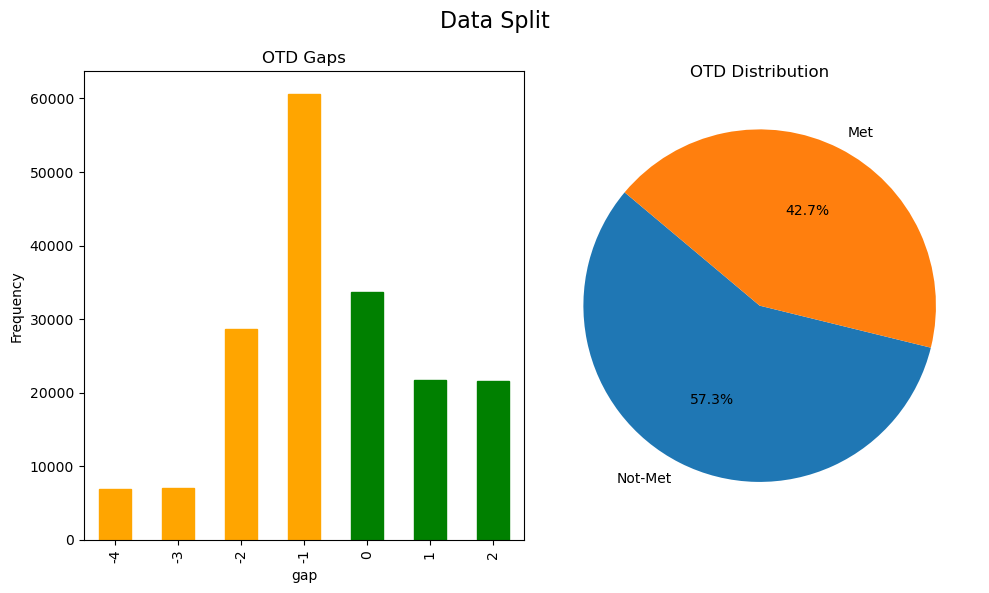

In [214]:
#visualizing this

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

fig.suptitle('Data Split', fontsize=16)

# Plot 1: Bar chart
ax = data_df['gap'].value_counts().sort_index().plot(kind='bar', title='OTD Gaps', ylabel='Frequency', ax=axes[0])
bars = ax.patches
for bar, value in zip(bars, data_df['gap'].value_counts().sort_index().index):
    if value < 0:
        bar.set_color('orange')
    else:
        bar.set_color('green')

# Plot 2: Pie chart
axes[1].pie(data_df['otd'].value_counts(), labels=np.where(data_df['otd'].value_counts().index == 1, 'Met', 'Not-Met'), autopct='%1.1f%%', startangle=140)  # Add autopct for percentages
axes[1].set_title('OTD Distribution')  # Add a title to the pie chart

plt.tight_layout()
plt.savefig(r'C:\data\capstone\analysis\target_analysis.png')
plt.show()

Based on this, there is an approxiamte 60/40 split between 'not-met' and 'met' scenarios. We would need to keep this in mind as we start modeling the data. 

### Features 

In [8]:
X = data_df

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 55 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 180519 non-null  object 
 12  Customer Fname                

In [10]:
X.describe()

Days for shipping (real)  Days for shipment (scheduled)  \
count             180519.000000                  180519.000000   
mean                   3.497654                       2.931847   
std                    1.623722                       1.374449   
min                    0.000000                       0.000000   
25%                    2.000000                       2.000000   
50%                    3.000000                       4.000000   
75%                    5.000000                       4.000000   
max                    6.000000                       4.000000   

       Benefit per order  Sales per customer  Late_delivery_risk  \
count      180519.000000       180519.000000       180519.000000   
mean           21.974989          183.107609            0.548291   
std           104.433526          120.043670            0.497664   
min         -4274.979980            7.490000            0.000000   
25%             7.000000          104.379997            0.000000   
50%            31.520000          163.990005            1.000000   
75%            64.800003          247.399994            1.000000   
max           911.799988         1939.989990            1.000000   

         Category Id    Customer Id  Customer Zipcode  Department Id  \
count  180519.000000  180519.000000     180516.000000  180519.000000   
mean       31.851451    6691.379495      35921.126914       5.443460   
std        15.640064    4162.918106      37542.461122       1.629246   
min         2.000000       1.000000        603.000000       2.000000   
25%        18.000000    3258.500000        725.000000       4.000000   
50%        29.000000    6457.000000      19380.000000       5.000000   
75%        45.000000    9779.000000      78207.000000       7.000000   
max        76.000000   20757.000000      99205.000000      12.000000   

            Latitude  ...  Order Item Total  Order Profit Per Order  \
count  180519.000000  ...     180519.000000           180519.000000   
mean       29.719955  ...        183.107609               21.974989   
std         9.813646  ...        120.043670              104.433526   
min       -33.937553  ...          7.490000            -4274.979980   
25%        18.265432  ...        104.379997                7.000000   
50%        33.144863  ...        163.990005               31.520000   
75%        39.279617  ...        247.399994               64.800003   
max        48.781933  ...       1939.989990              911.799988   

       Order Zipcode  Product Card Id  Product Category Id  \
count   24840.000000    180519.000000        180519.000000   
mean    55426.132327       692.509764            31.851451   
std     31919.279101       336.446807            15.640064   
min      1040.000000        19.000000             2.000000   
25%     23464.000000       403.000000            18.000000   
50%     59405.000000       627.000000            29.000000   
75%     90008.000000      1004.000000            45.000000   
max     99301.000000      1363.000000            76.000000   

       Product Description  Product Price  Product Status            gap  \
count                  0.0  180519.000000        180519.0  180519.000000   
mean                   NaN     141.232550             0.0      -0.565807   
std                    NaN     139.732492             0.0       1.490966   
min                    NaN       9.990000             0.0      -4.000000   
25%                    NaN      50.000000             0.0      -1.000000   
50%                    NaN      59.990002             0.0      -1.000000   
75%                    NaN     199.990005             0.0       0.000000   
max                    NaN    1999.989990             0.0       2.000000   

                 otd  
count  180519.000000  
mean        0.427207  
std         0.494674  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         1.000000  
max         1.000000  

[8 rows x 31 columns]

Some of these columns are either keys or, highly correlated with each other, which will not help in identifying issues and hence should be removed
- Order Id, Order Customer Id, Order Item Id : Key
- Category Name : Co-rrelated to Category Id
- Customer Email, Customer Fname, Customer Lname, Customer Password : Co-rrelated to Customer Id 
- Department Name : Co-rrelated to Department Id
- Product Image, Product Name, Product Description: Co-rrelated to  Product Card Id


Other items to ponder
- Group order date and shipping date into week, day of week and month buckets
- Also consider to add the gap between order date and shipping date


In [11]:
X_rationalized = X.drop(['Order Id', 'Order Customer Id', 'Order Item Id', 'Category Name', 'Customer Email', 'Customer Fname', 'Customer Lname', 'Customer Password', 'Department Name', 'Product Description','Product Image', 'Product Name'], axis = 1)

In [12]:
#understand content of X_rationalized
data_zip = zip(X_rationalized.columns, X_rationalized.dtypes, X_rationalized.isnull().sum(), X_rationalized.nunique(), np.round((X_rationalized.isnull().sum()/X_rationalized.shape[0])*100,2))
data_col = pd.DataFrame(data_zip, columns=['Column Name', 'Type', 'Null Count', 'Unique Count', 'Null %'])
data_col.set_index('Column Name', inplace = True)
data_col

Type  Null Count  Unique Count  Null %
Column Name                                                             
Type                            object           0             4    0.00
Days for shipping (real)         int64           0             7    0.00
Days for shipment (scheduled)    int64           0             4    0.00
Benefit per order              float64           0         21998    0.00
Sales per customer             float64           0          2927    0.00
Delivery Status                 object           0             4    0.00
Late_delivery_risk               int64           0             2    0.00
Category Id                      int64           0            51    0.00
Customer City                   object           0           563    0.00
Customer Country                object           0             2    0.00
Customer Id                      int64           0         20652    0.00
Customer Segment                object           0             3    0.00
Customer State                  object           0            46    0.00
Customer Street                 object           0          7458    0.00
Customer Zipcode               float64           3           995    0.00
Department Id                    int64           0            11    0.00
Latitude                       float64           0         11250    0.00
Longitude                      float64           0          4487    0.00
Market                          object           0             5    0.00
Order City                      object           0          3597    0.00
Order Country                   object           0           164    0.00
order date (DateOrders)         object           0         65752    0.00
Order Item Cardprod Id           int64           0           118    0.00
Order Item Discount            float64           0          1017    0.00
Order Item Discount Rate       float64           0            18    0.00
Order Item Product Price       float64           0            75    0.00
Order Item Profit Ratio        float64           0           162    0.00
Order Item Quantity              int64           0             5    0.00
Sales                          float64           0           193    0.00
Order Item Total               float64           0          2927    0.00
Order Profit Per Order         float64           0         21998    0.00
Order Region                    object           0            23    0.00
Order State                     object           0          1089    0.00
Order Status                    object           0             9    0.00
Order Zipcode                  float64      155679           609   86.24
Product Card Id                  int64           0           118    0.00
Product Category Id              int64           0            51    0.00
Product Price                  float64           0            75    0.00
Product Status                   int64           0             1    0.00
shipping date (DateOrders)      object           0         63701    0.00
Shipping Mode                   object           0             4    0.00
gap                              int64           0             7    0.00
otd                              int64           0             2    0.00

Order Zip code has a large amount of null. This column can be removed. There are three records with Customer zip as Null. Lets remove those rows as well

In [13]:
X_rationalized.drop('Order Zipcode', axis = 1, inplace=True)
X_rationalized.dropna(subset = ['Customer Zipcode'], inplace = True)

Convert Dates to Epochs as well as specific components

In [14]:
#shipping date (DateOrders), order date (DateOrders). We will split this to epoch, day of week, week of year, month and year 
for col in ['shipping date (DateOrders)', 'order date (DateOrders)' ]:
    X_rationalized[col] = pd.to_datetime(X_rationalized[col])
    X_rationalized[f'{col.split()[0]}_epoch'] = X_rationalized[col].apply(lambda x: x.timestamp())
    X_rationalized[f'{col.split()[0]}_dayofweek'] = X_rationalized[col].dt.dayofweek
    X_rationalized[f'{col.split()[0]}_weekofyear'] = X_rationalized[col].dt.isocalendar().week.astype(int) 
    X_rationalized[f'{col.split()[0]}_month'] = X_rationalized[col].dt.month
    X_rationalized[f'{col.split()[0]}_year'] = X_rationalized[col].dt.year
    X_rationalized[f'{col.split()[0]}_dayofmonth'] = X_rationalized[col].dt.day 
X_rationalized.drop(['shipping date (DateOrders)', 'order date (DateOrders)'], axis = 1, inplace=True)

In [15]:
#understand content of X_rationalized
data_zip = zip(X_rationalized.columns, X_rationalized.dtypes, X_rationalized.isnull().sum(), X_rationalized.nunique(), np.round((X_rationalized.isnull().sum()/X_rationalized.shape[0])*100,2))
data_col = pd.DataFrame(data_zip, columns=['Column Name', 'Type', 'Null Count', 'Unique Count', 'Null %'])
data_col.set_index('Column Name', inplace = True)
data_col

Type  Null Count  Unique Count  Null %
Column Name                                                             
Type                            object           0             4     0.0
Days for shipping (real)         int64           0             7     0.0
Days for shipment (scheduled)    int64           0             4     0.0
Benefit per order              float64           0         21998     0.0
Sales per customer             float64           0          2927     0.0
Delivery Status                 object           0             4     0.0
Late_delivery_risk               int64           0             2     0.0
Category Id                      int64           0            51     0.0
Customer City                   object           0           562     0.0
Customer Country                object           0             2     0.0
Customer Id                      int64           0         20649     0.0
Customer Segment                object           0             3     0.0
Customer State                  object           0            44     0.0
Customer Street                 object           0          7456     0.0
Customer Zipcode               float64           0           995     0.0
Department Id                    int64           0            11     0.0
Latitude                       float64           0         11248     0.0
Longitude                      float64           0          4485     0.0
Market                          object           0             5     0.0
Order City                      object           0          3597     0.0
Order Country                   object           0           164     0.0
Order Item Cardprod Id           int64           0           118     0.0
Order Item Discount            float64           0          1017     0.0
Order Item Discount Rate       float64           0            18     0.0
Order Item Product Price       float64           0            75     0.0
Order Item Profit Ratio        float64           0           162     0.0
Order Item Quantity              int64           0             5     0.0
Sales                          float64           0           193     0.0
Order Item Total               float64           0          2927     0.0
Order Profit Per Order         float64           0         21998     0.0
Order Region                    object           0            23     0.0
Order State                     object           0          1089     0.0
Order Status                    object           0             9     0.0
Product Card Id                  int64           0           118     0.0
Product Category Id              int64           0            51     0.0
Product Price                  float64           0            75     0.0
Product Status                   int64           0             1     0.0
Shipping Mode                   object           0             4     0.0
gap                              int64           0             7     0.0
otd                              int64           0             2     0.0
shipping_epoch                 float64           0         63699     0.0
shipping_dayofweek               int32           0             7     0.0
shipping_weekofyear              int32           0            53     0.0
shipping_month                   int32           0            12     0.0
shipping_year                    int32           0             4     0.0
shipping_dayofmonth              int32           0            31     0.0
order_epoch                    float64           0         65749     0.0
order_dayofweek                  int32           0             7     0.0
order_weekofyear                 int32           0            53     0.0
order_month                      int32           0            12     0.0
order_year                       int32           0             4     0.0
order_dayofmonth                 int32           0            31     0.0

In [226]:
df = X_rationalized.drop(['order_epoch','shipping_epoch', 'Days for shipping (real)', 'gap'], axis = 1)
df['otd'] = df['otd'].apply(lambda x: 'met' if x ==1 else 'not-met')

In [227]:
import math
numerical_cols = df.select_dtypes(include=['number']).columns
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols.size, categorical_cols.size

(33, 15)

#### Categorical Features spread

'Other' category in Customer City represents 52.12% of the data
'Other' category in Customer Country represents 0.00% of the data
'Other' category in Customer Segment represents 0.00% of the data
'Other' category in Customer State represents 18.55% of the data
'Other' category in Customer Street represents 99.39% of the data
'Other' category in Delivery Status represents 0.00% of the data
'Other' category in Market represents 0.00% of the data
'Other' category in Order City represents 90.93% of the data
'Other' category in Order Country represents 44.54% of the data
'Other' category in Order Region represents 26.14% of the data
'Other' category in Order State represents 80.63% of the data
'Other' category in Order Status represents 0.00% of the data
'Other' category in Shipping Mode represents 0.00% of the data
'Other' category in Type represents 0.00% of the data


<Figure size 640x480 with 0 Axes>

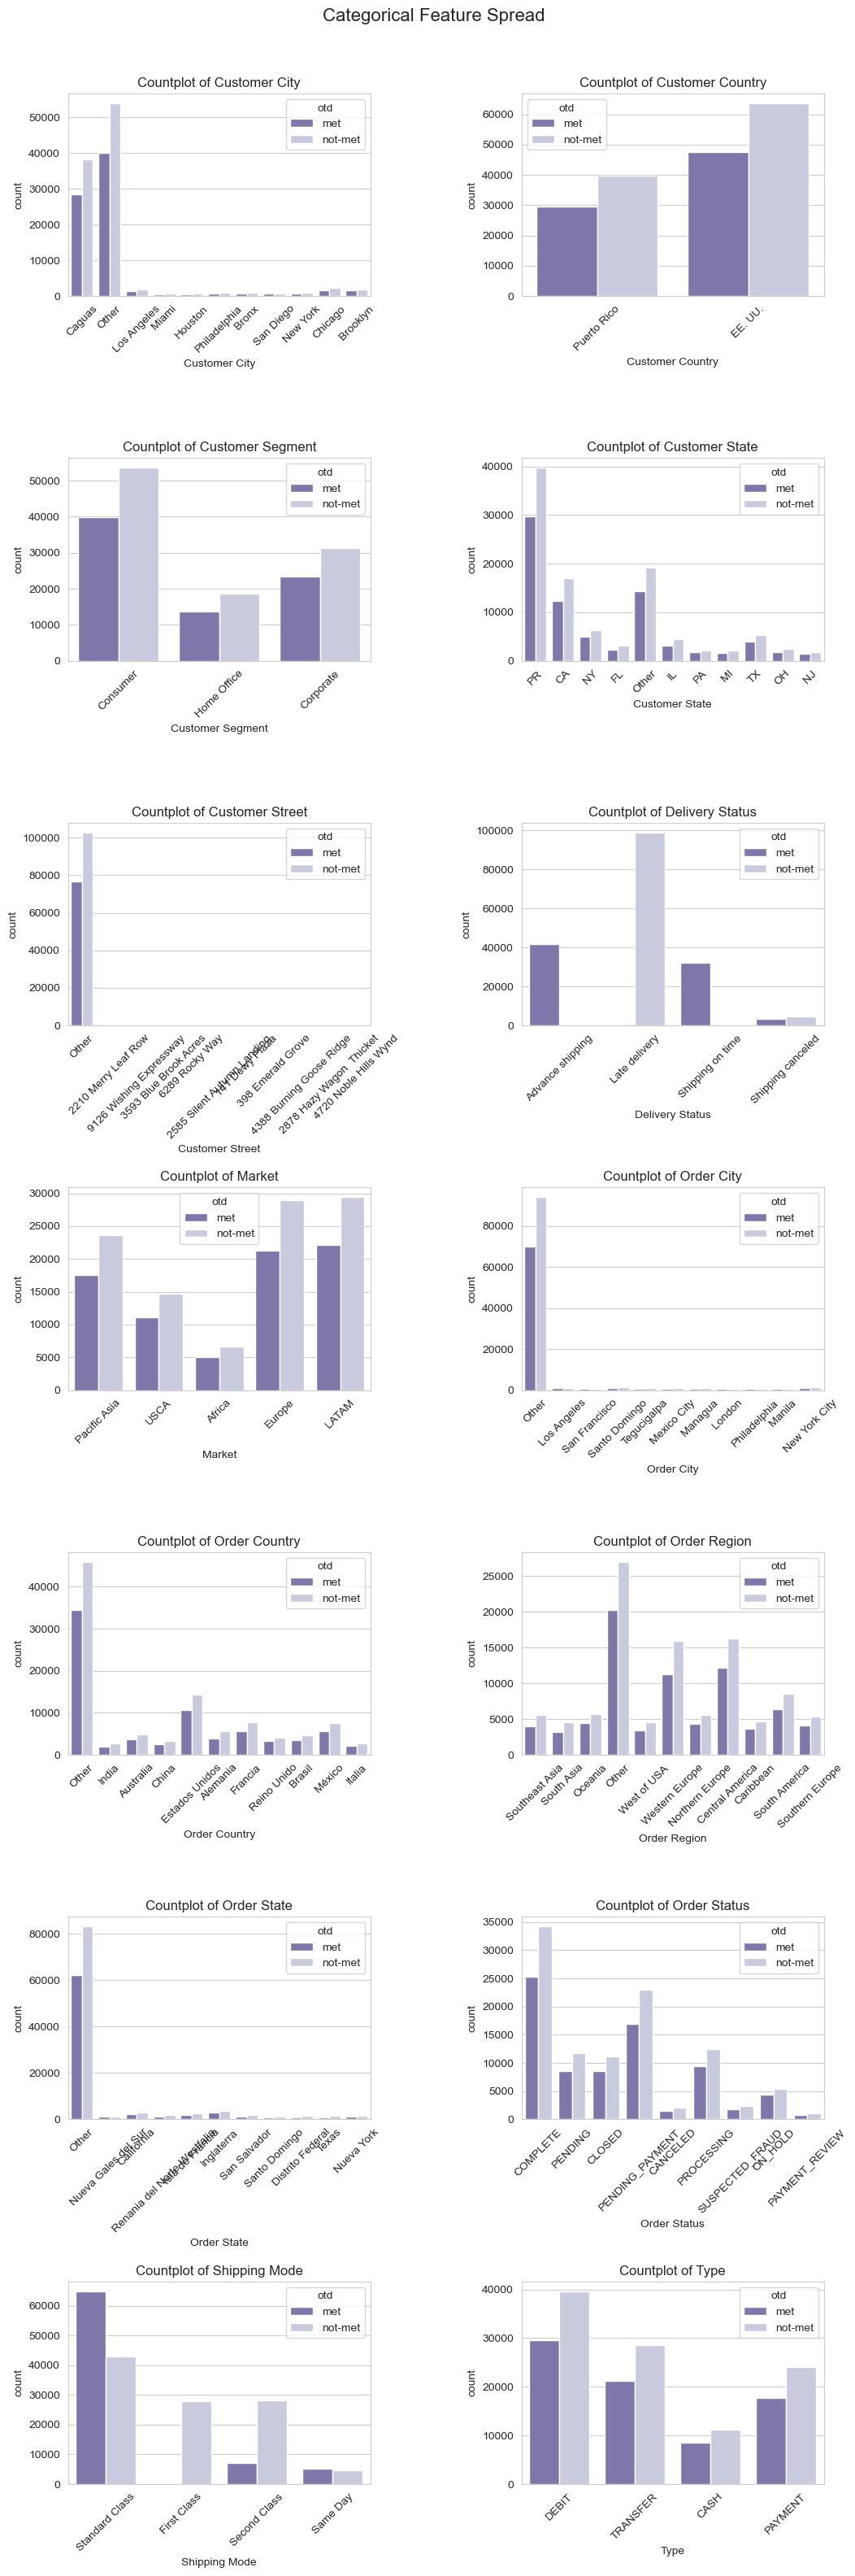

In [245]:
# Bar charts for categorical features
n_cols = 2  # Number of columns in the subplot grid
n_rows = math.ceil(len(categorical_cols.difference(['otd'])) / n_cols)

sns.set_style("whitegrid") 
sns.despine(left=True, bottom=True)

# Create subplots for categorical features
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows), gridspec_kw={'top': 0.95})
fig.suptitle('Categorical Feature Spread', fontsize = 16)
plt.subplots_adjust(hspace=0.8)
plt.subplots_adjust(wspace=0.5)

# Loop through the categorical columns
for i, col in enumerate(categorical_cols.difference(['otd'])):

    row = i // n_cols
    col_index = i % n_cols

    # Calculate value counts
    value_counts = df[col].value_counts()

    top_n = 10  # Display the top 10 categories

    # Get the top N categories and 'Other'
    top_n_labels = value_counts[:top_n].index.tolist()
    other_label = 'Other'

    # Create a new column with combined categories
    df['combined_' + col] = np.where(df[col].isin(top_n_labels), df[col], other_label)

    # Use the 'hue' parameter with the combined column
    sns.countplot(data=df, x='combined_' + col, hue='otd', ax=axes[row, col_index], palette='Purples_r')

    axes[row, col_index].set_title(f'Countplot of {col}')
    axes[row, col_index].set_xlabel(col)
    axes[row, col_index].tick_params(axis='x', rotation=45)

    # Calculate the percentage of 'Other'
    other_percentage = (len(df[df['combined_' + col] == other_label]) / len(df)) * 100
    print(f"'Other' category in {col} represents {other_percentage:.2f}% of the data")
   
# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
# Save image
plt.savefig(r'C:\data\capstone\analysis\categorical_analysis_count_plots.png', dpi=300, bbox_inches='tight')
plt.show()

Delivery Status tracks the shipping status, and hence, OTD directly. This field should be removed. Further, the cancelled shipments should not be considered for this analysis. They would be removed as well.

As 'Other' category in Customer Street represents 99.39% of the data, we will remove field as categorizing this would result in computational inefficiencies as well as overfitting

#### Numerical Features Spread

<Figure size 640x480 with 0 Axes>

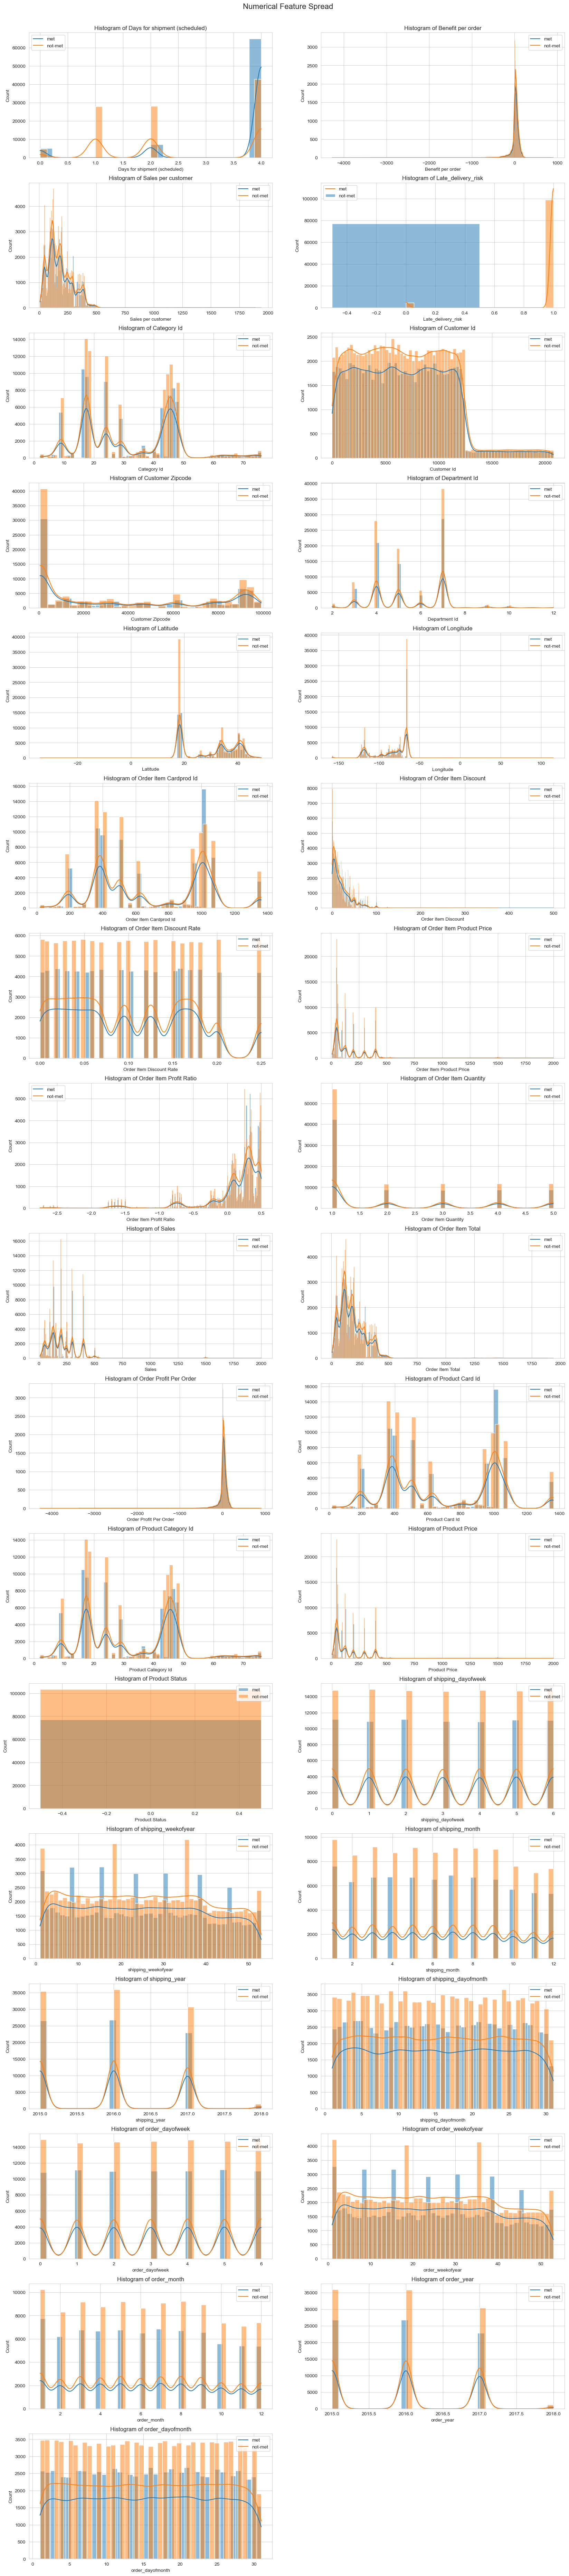

In [260]:
# Histogram for numerical features

# Calculate the number of rows and columns for the subplots
n_cols = 2  
n_rows = math.ceil(len(numerical_cols) / n_cols)

sns.color_palette("Purples_r")
sns.set_style("whitegrid") 
sns.despine(left=True, bottom=True)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows), gridspec_kw={'top': 0.97}) 
fig.suptitle('Numerical Feature Spread', fontsize = 16)
# plt.subplots_adjust(wspace=0.4)
# plt.subplots_adjust(hspace=0.4)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through the numerical columns and create histograms in the subplots
for i, col in enumerate(numerical_cols):
    for target_val in df['otd'].unique():
        sns.histplot(df[df['otd'] == target_val][col], ax=axes[i], kde=True, label=target_val, alpha = 0.5, palette = 'Purples_r')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].legend(['met', 'not-met'])

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


# Adjust layout to prevent overlapping
plt.tight_layout()

# Save image
plt.savefig(r'C:\data\capstone\analysis\numerical_analysis_histograms.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

Do not see any obvious direct relationships between the various numberical fields and the target, but, product status field is alwas 0. That can be removed

In [20]:
df.drop(['Customer Street', 'Delivery Status', 'Product Status'], axis = 1, inplace = True, errors='ignore')
categorical_cols = categorical_cols.difference(['Customer Street','Delivery Status'])
numerical_cols = numerical_cols.difference(['Product Status'])

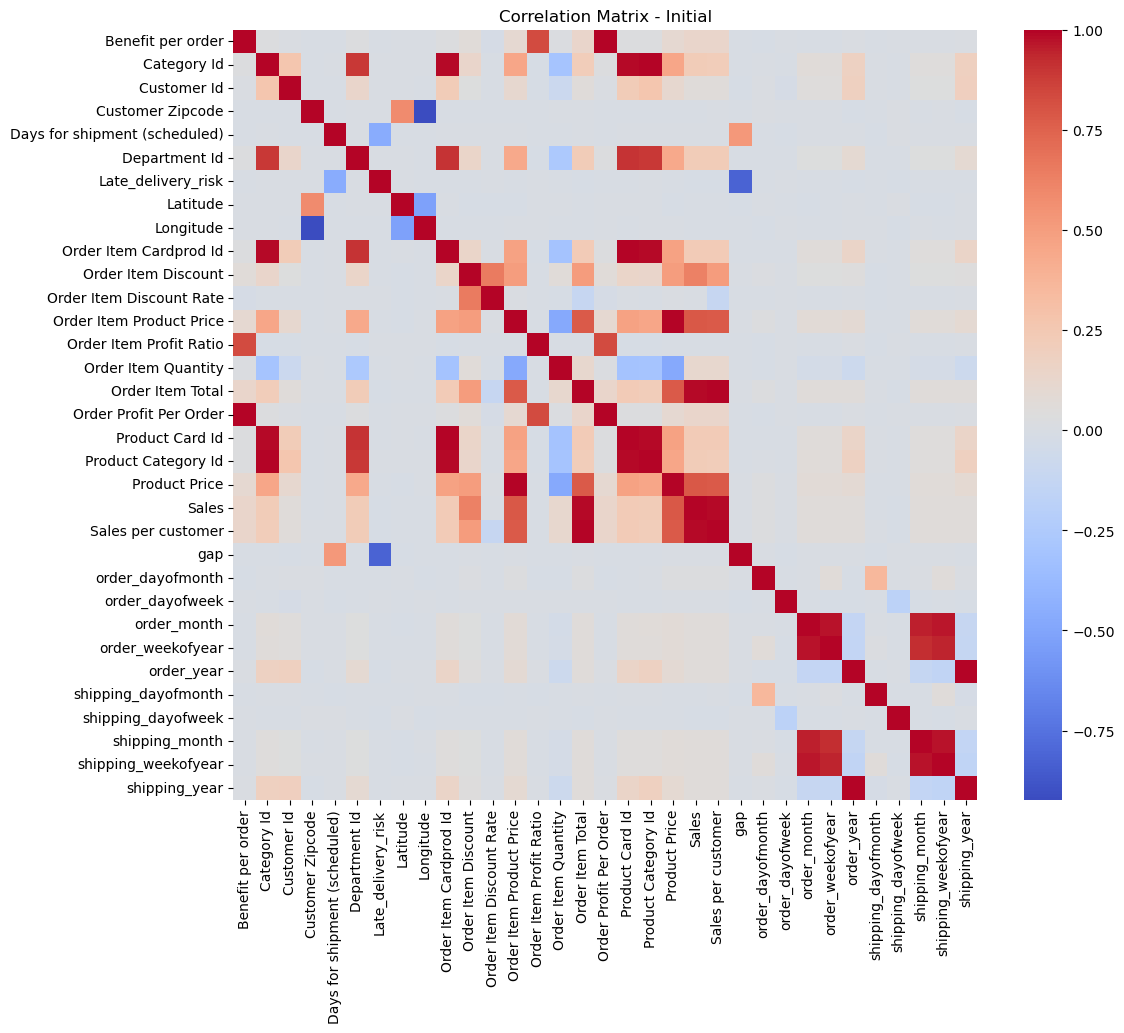

In [97]:
# Correlation matrix heatmap
corr_matrix = df_small[numerical_cols].corr()
plt.figure(figsize=(12, 10)) 
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix - Initial')
plt.savefig(r'C:\data\capstone\analysis\corr_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

 - Order Dates and Shipping dates have very high correlation. Further, the month and weeks have high correlation as well. Hence, dropping those. Further, Order with 'Shipping Cancelled' status should be removed
 - 'Category Id', 'Department Id', 'Product Category Id', 'Product Card Id' and 'Order Item Cardprod Id' have high positive correlation. To reduce computation, will only keep the 'Department Id' and drop the others
 - 'Order Item Total' has very high correlation with 'Product Price' and 'Sales per customer'. Only 'Product Price Benefit per order' will be kept
 - 'Order Profit Per Order' and 'Order Item Profit Ratio' are highly correlated. Will keep only the latter
 - 'Order Item Product Price' and 'Product Price' are highly correlated. Keeping only the latter here as well
 - 'Order Item Quantity' and 'Product price' have a very high inverse relationship. Will keep 'Order Item Quantity'
 - 'Order Item Discount' and 'Order Item Discount Rate' have high correlation. Only keeping the latter
 - 'Late Delivery Risk' and 'Gap' have high correlation, and it looks like it is captured based on actual shipping data. Hence, removing it
 - 'Customer Zip Code' and 'longitude/latitude' have a very high correlation. Removing the former former


In [23]:
data_final = X_rationalized[X_rationalized['Delivery Status'] != 'Shipping canceled']

data_final = data_final.drop(['Customer Street', 'Product Status',  'Delivery Status',
                                  'shipping_weekofyear', 'shipping_month','shipping_year', 'order_weekofyear',
                                  'Product Card Id', 'Order Item Cardprod Id', 'Product Category Id', 'Category Id',
                                  'Order Item Total', 'Sales per customer',
                                  'Order Profit Per Order', 'Order Item Profit Ratio',
                                  'Late_delivery_risk',
                                  'Product Price',
                                  'Order Item Product Price', 'Order Item Discount',
                                  'Customer Zipcode',
                                  'order_epoch', 'shipping_epoch'], axis = 1)

numerical_cols_final = data_final.select_dtypes(include=['number']).columns
categorical_cols_final = data_final.select_dtypes(include=['object']).columns

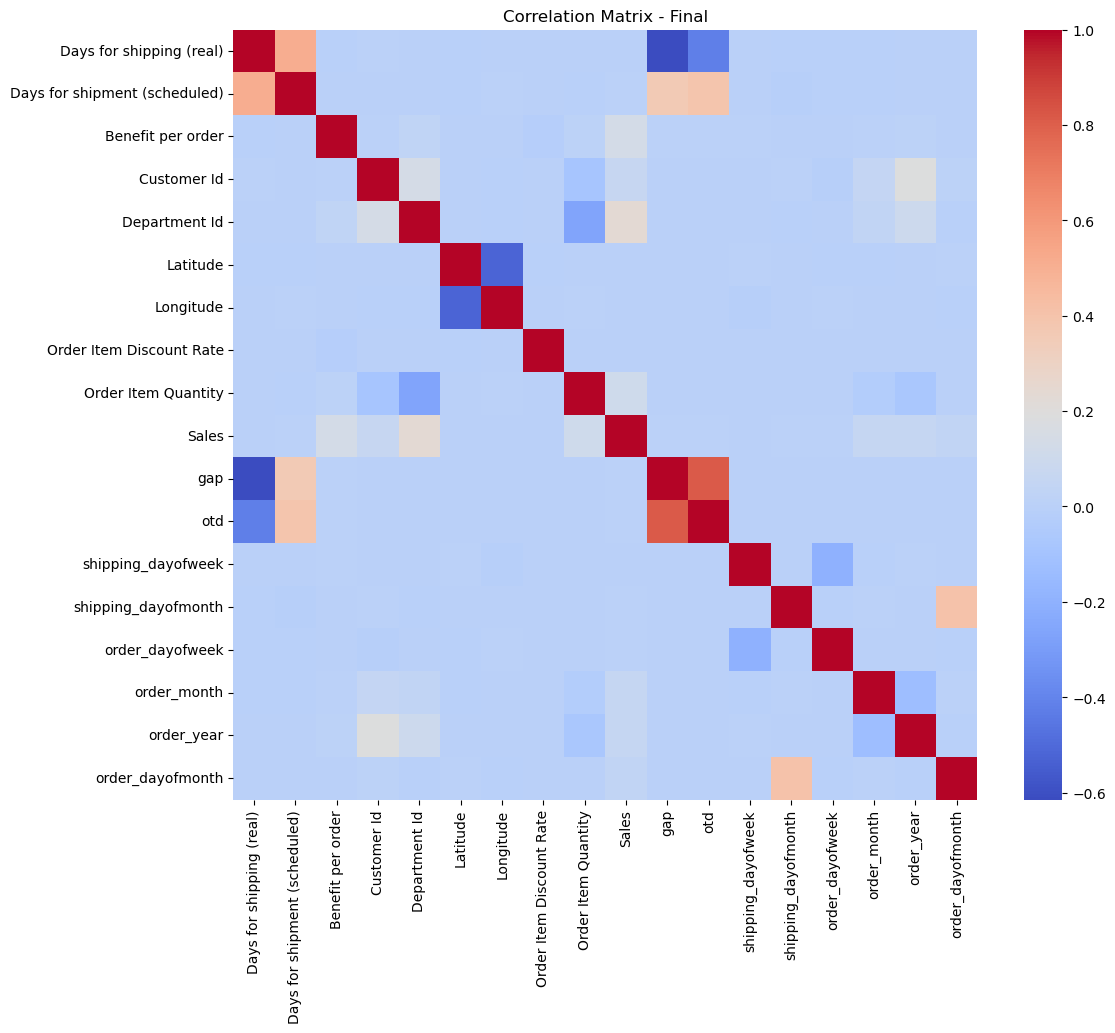

In [98]:
# Correlation matrix heatmap
corr_matrix_final = data_final[numerical_cols_final].corr()
plt.figure(figsize=(12, 10)) 
sns.heatmap(corr_matrix_final, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix - Final')
plt.savefig(r'C:\data\capstone\analysis\corr_matrix_final.png', dpi=300, bbox_inches='tight')
plt.show()

In [25]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172762 entries, 0 to 180518
Data columns (total 30 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           172762 non-null  object 
 1   Days for shipping (real)       172762 non-null  int64  
 2   Days for shipment (scheduled)  172762 non-null  int64  
 3   Benefit per order              172762 non-null  float64
 4   Customer City                  172762 non-null  object 
 5   Customer Country               172762 non-null  object 
 6   Customer Id                    172762 non-null  int64  
 7   Customer Segment               172762 non-null  object 
 8   Customer State                 172762 non-null  object 
 9   Department Id                  172762 non-null  int64  
 10  Latitude                       172762 non-null  float64
 11  Longitude                      172762 non-null  float64
 12  Market                         1727

In [26]:
data_final[['Benefit per order', 'Latitude', 'Longitude', 'Sales']] = data_final[['Benefit per order', 'Latitude', 'Longitude', 'Sales']].astype(int)

In [27]:
#understand content of data_final
data_final_zip = zip(data_final.columns, data_final.dtypes, data_final.isnull().sum(), data_final.nunique(), np.round((data_final.isnull().sum()/data_final.shape[0])*100,2))
data_final_col = pd.DataFrame(data_final_zip, columns=['Column Name', 'Type', 'Null Count', 'Unique Count', 'Null %'])
data_final_col.set_index('Column Name', inplace = True)
data_final_col

Type  Null Count  Unique Count  Null %
Column Name                                                             
Type                            object           0             4     0.0
Days for shipping (real)         int64           0             7     0.0
Days for shipment (scheduled)    int64           0             4     0.0
Benefit per order                int32           0          1273     0.0
Customer City                   object           0           562     0.0
Customer Country                object           0             2     0.0
Customer Id                      int64           0         20258     0.0
Customer Segment                object           0             3     0.0
Customer State                  object           0            44     0.0
Department Id                    int64           0            11     0.0
Latitude                         int32           0            28     0.0
Longitude                        int32           0            64     0.0
Market                          object           0             5     0.0
Order City                      object           0          3585     0.0
Order Country                   object           0           164     0.0
Order Item Discount Rate       float64           0            18     0.0
Order Item Quantity              int64           0             5     0.0
Sales                            int32           0           126     0.0
Order Region                    object           0            23     0.0
Order State                     object           0          1083     0.0
Order Status                    object           0             7     0.0
Shipping Mode                   object           0             4     0.0
gap                              int64           0             7     0.0
otd                              int64           0             2     0.0
shipping_dayofweek               int32           0             7     0.0
shipping_dayofmonth              int32           0            31     0.0
order_dayofweek                  int32           0             7     0.0
order_month                      int32           0            12     0.0
order_year                       int32           0             4     0.0
order_dayofmonth                 int32           0            31     0.0

## Modeling

First, Let us approach this as a classification problem - Can the system predict if this order would be delivered on time or not?

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, recall_score, precision_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

In [29]:
# For this, target is the otd column. So, let us create X and y accordingly
data_class = data_final.drop(['gap', 'Days for shipping (real)'], axis = 1)

As the dataset is large, running the tests on full datasets is computationally expensive. Hence, using a randomly sampled, 50% mix with the same met/not-met split

In [30]:
prob2 = data_class['otd'].value_counts(normalize=True)
weights2 = 1 / prob
weights_alingned2 = data_class['otd'].map(weights)
df_final_small = data_class.sample(frac=0.5, weights=weights_alingned, random_state=42)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df_final_small.drop(['otd'], axis =1),df_final_small['otd'], shuffle=True, test_size = 0.2 ,stratify=df_final_small['otd'])

In [32]:
transformer = make_column_transformer(
    (OrdinalEncoder(categories = [['Second Class','Standard Class','First Class','Same Day']],handle_unknown='use_encoded_value', unknown_value=-1),['Shipping Mode']),
    (OneHotEncoder(drop='if_binary', handle_unknown='infrequent_if_exist'),X_train.select_dtypes(include=['object', 'category']).columns.difference(['Shipping Mode'])),
    remainder=StandardScaler()   
)

In [33]:
# LEts Try some classifiers with the reduced dataset to see what is good
# Params for KNN
params_kn = {
    'classifier__n_neighbors': [5,11,31,51,71,91],  # Number of neighbors
    'classifier__weights': ['uniform', 'distance'],  # Weighting scheme
    'classifier__metric': ['euclidean', 'manhattan'],  # Distance metric
    'classifier__algorithm' : ['kd_tree']
}
# Params for DTree
params_dtree = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None,10,20,30,50,100],
    'classifier__min_samples_split': [2, 5, 10, 20],
    'classifier__min_samples_leaf': [1, 2, 5, 10],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__class_weight': ['balanced', None]
}

# Params for LR
params_lr = {
    'classifier__penalty': ['l2'],
    'classifier__C': [0.01, 0.1, 1, 10, 100, 1000, 10000],
    'classifier__solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg'],
    'classifier__class_weight': ['balanced', None]
}
# Params for SVC - deciding to go with rbf kernel in the interst of computational efficiency
params_svc = {
    'classifier__C': [1, 10],  # Regularization parameter
    'classifier__kernel': ['rbf', 'poly'],  # Kernel type - reducing due to performance limitations
    'classifier__gamma': ['scale', 'auto'],  # Kernel coefficient
    'classifier__degree': [3,4]
}

In [34]:
type_of_model = []
train_score_prec=[]
train_score_aoc=[]
train_score_recall=[]
test_score_prec=[]
test_score_aoc=[]
test_score_recall=[]
param_values = []
fit_time = []
score_time = []

In [35]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def GridSearch_and_score(name, params, estimator, scoring):
    estimator_clone = clone(estimator) 
    grid = GridSearchCV(estimator=create_pipeline(estimator_clone), 
                        param_grid=params, 
                        n_jobs=40, 
                        scoring= scoring, 
                        error_score = 'raise',
                        cv = skf,
                        # refit = False,
                        verbose=2
                       ).fit(X_train, y_train)
    
    type_of_model.append(name)
    param_values.append(grid.best_params_)
    
    train_score_recall.append(grid.score(X_train, y_train))
    test_score_recall.append(grid.score(X_test, y_test))
    
    train_score_prec.append(precision_score(grid.best_estimator_.predict(X_train),y_train))
    test_score_prec.append(precision_score(grid.best_estimator_.predict(X_test),y_test))
    
    train_score_aoc.append(roc_auc_score(grid.best_estimator_.predict(X_train),y_train))
    test_score_aoc.append(roc_auc_score(grid.best_estimator_.predict(X_test),y_test))    
    
    fit_time.append(grid.cv_results_['mean_fit_time'].mean())
    score_time.append(grid.cv_results_['mean_score_time'].mean())
    
    return grid

In [36]:
def create_pipeline(classifier):
    pipeline = Pipeline([
        ('transform', transformer),
        ('classifier', classifier)
    ])
    return pipeline

In [37]:
#Recall is the metric to go after as we need to clearly idenltify the "Not Met" use case
grid_lr = GridSearch_and_score('Logistics Regression - Default', {}, LogisticRegression(max_iter=10000), 'recall')
grid_knn = GridSearch_and_score('KNN - Default', {}, KNeighborsClassifier(), 'recall')
grid_dtree = GridSearch_and_score('DTree - Default', {}, DecisionTreeClassifier(), 'recall')
grid_svc = GridSearch_and_score('SVC - Default', {}, SVC(), 'recall')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [38]:
grid_lr_a = GridSearch_and_score('Logistics Regression - Tuned for Recall', params_lr, LogisticRegression(max_iter=10000),  'recall')
print('Best Param:' + str(grid_lr_a.best_params_))

Fitting 5 folds for each of 56 candidates, totalling 280 fits
Best Param:{'classifier__C': 0.01, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


In [39]:
grid_knn_a = GridSearch_and_score('KNN - Tuned for Recall', params_kn, KNeighborsClassifier(), 'recall')
print('Best Param:' + str(grid_knn_a.best_params_))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Param:{'classifier__algorithm': 'kd_tree', 'classifier__metric': 'manhattan', 'classifier__n_neighbors': 31, 'classifier__weights': 'distance'}


In [40]:
grid_dtree_a = GridSearch_and_score('DTree - Tuned for Recall', params_dtree, DecisionTreeClassifier(),  'recall')
print('Best Param:' + str(grid_dtree_a.best_params_))

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
Best Param:{'classifier__class_weight': 'balanced', 'classifier__criterion': 'entropy', 'classifier__max_depth': 100, 'classifier__max_features': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5}


In [41]:
grid_svc_a = GridSearch_and_score('SVC - Tuned for Recall', params_svc, SVC(), 'recall')
print('Best Param:' + str(grid_svc_a.best_params_))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Param:{'classifier__C': 10, 'classifier__degree': 3, 'classifier__gamma': 'scale', 'classifier__kernel': 'poly'}


In [42]:
len(type_of_model), len(param_values), len(train_score_aoc), len(train_score_prec), len(fit_time), len(score_time), len(test_score_prec), len(test_score_aoc)

(8, 8, 8, 8, 8, 8, 8, 8)

In [43]:
df_grid = pd.DataFrame({'model': type_of_model, 
                        'params' : param_values, 
                        'train recall':train_score_recall, 
                        'test recall':test_score_recall,
                        'train AUC-ROC':train_score_aoc, 
                        'test AUC-ROC':test_score_aoc,
                        'train Precision':train_score_prec, 
                        'test Precision':test_score_prec, 
                        'fit time': fit_time, 
                        'score time':score_time })
pd.options.display.max_colwidth = None
df_grid.set_index('model')

params  \
model                                                                                                                                                                                                                                                          
Logistics Regression - Default                                                                                                                                                                                                                            {}   
KNN - Default                                                                                                                                                                                                                                             {}   
DTree - Default                                                                                                                                                                                                                                           {}   
SVC - Default                                                                                                                                                                                                                                             {}   
Logistics Regression - Tuned for Recall                                                                                      {'classifier__C': 0.01, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}   
KNN - Tuned for Recall                                                                                             {'classifier__algorithm': 'kd_tree', 'classifier__metric': 'manhattan', 'classifier__n_neighbors': 31, 'classifier__weights': 'distance'}   
DTree - Tuned for Recall                 {'classifier__class_weight': 'balanced', 'classifier__criterion': 'entropy', 'classifier__max_depth': 100, 'classifier__max_features': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5}   
SVC - Tuned for Recall                                                                                                                            {'classifier__C': 10, 'classifier__degree': 3, 'classifier__gamma': 'scale', 'classifier__kernel': 'poly'}   

                                         train recall  test recall  \
model                                                                
Logistics Regression - Default               0.843510     0.825481   
KNN - Default                                0.921665     0.850962   
DTree - Default                              1.000000     0.949760   
SVC - Default                                0.970883     0.941827   
Logistics Regression - Tuned for Recall      0.866256     0.868750   
KNN - Tuned for Recall                       1.000000     0.892909   
DTree - Tuned for Recall                     0.999579     0.989663   
SVC - Tuned for Recall                       0.999970     0.985337   

                                         train AUC-ROC  test AUC-ROC  \
model                                                                  
Logistics Regression - Default                0.771839      0.746329   
KNN - Default                                 0.904294      0.820119   
DTree - Default                               1.000000      0.946286   
SVC - Default                                 0.955521      0.917057   
Logistics Regression - Tuned for Recall       0.757026      0.753813   
KNN - Tuned for Recall                        1.000000      0.820008   
DTree - Tuned for Recall                      0.864261      0.848974   
SVC - Tuned for Recall                        0.999986      0.982344   

                                         train Precision  test Precision  \
model                                                                      
Logistics Regression - Default                  0.843510        0.825481   
KNN - Default                      

In [44]:
#based on this, SVC is excellent. As Dtree improves with more data, trying dTree out with full data
#As a first step, let us do this with the full dataset
X_train_first, X_test, y_train_first, y_test = train_test_split(data_class.drop(['otd'], axis =1),data_class['otd'], shuffle=True, test_size = 0.2 ,stratify=data_class['otd'])
X_train, X_hidden, y_train, y_hidden = train_test_split(X_train_first,y_train_first, shuffle=True, test_size = 0.2 ,stratify=y_train_first)

grid_dtree_a_full = GridSearch_and_score('DTree - Tuned for Recall - Full dataset', params_dtree, DecisionTreeClassifier(),  'recall')

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


In [45]:
df_grid = pd.DataFrame({'model': type_of_model, 'params' : param_values, 'train Recall':train_score_recall, 'train AUC-ROC':train_score_aoc, 'train Precision':train_score_prec,'test Recall':test_score_recall,'test AUC-ROC':test_score_aoc, 'test Precision':test_score_prec, 'fit time': fit_time, 'score time':score_time })
pd.options.display.max_colwidth = None
df_grid.set_index('model')

params  \
model                                                                                                                                                                                                                                                          
Logistics Regression - Default                                                                                                                                                                                                                            {}   
KNN - Default                                                                                                                                                                                                                                             {}   
DTree - Default                                                                                                                                                                                                                                           {}   
SVC - Default                                                                                                                                                                                                                                             {}   
Logistics Regression - Tuned for Recall                                                                                      {'classifier__C': 0.01, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}   
KNN - Tuned for Recall                                                                                             {'classifier__algorithm': 'kd_tree', 'classifier__metric': 'manhattan', 'classifier__n_neighbors': 31, 'classifier__weights': 'distance'}   
DTree - Tuned for Recall                 {'classifier__class_weight': 'balanced', 'classifier__criterion': 'entropy', 'classifier__max_depth': 100, 'classifier__max_features': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5}   
SVC - Tuned for Recall                                                                                                                            {'classifier__C': 10, 'classifier__degree': 3, 'classifier__gamma': 'scale', 'classifier__kernel': 'poly'}   
DTree - Tuned for Recall - Full dataset   {'classifier__class_weight': 'balanced', 'classifier__criterion': 'entropy', 'classifier__max_depth': 30, 'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}   

                                         train Recall  train AUC-ROC  \
model                                                                  
Logistics Regression - Default               0.843510       0.771839   
KNN - Default                                0.921665       0.904294   
DTree - Default                              1.000000       1.000000   
SVC - Default                                0.970883       0.955521   
Logistics Regression - Tuned for Recall      0.866256       0.757026   
KNN - Tuned for Recall                       1.000000       1.000000   
DTree - Tuned for Recall                     0.999579       0.864261   
SVC - Tuned for Recall                       0.999970       0.999986   
DTree - Tuned for Recall - Full dataset      0.999894       0.821367   

                                         train Precision  test Recall  \
model                                                                   
Logistics Regression - Default                  0.843510     0.825481   
KNN - Default                                   0.921665     0.850962   
DTree - Default                                 1.000000     0.949760   
SVC - Default                                   0.970883     0.941827   
Logistics Regression - Tuned for Recall         0.866256     0.868750   
KNN - Tuned for Recall                          1.000000     0.892909   
DTree - Tuned for Recall                        0.99

SVC was still better

### Now, lets check how effective the best model identified so far was

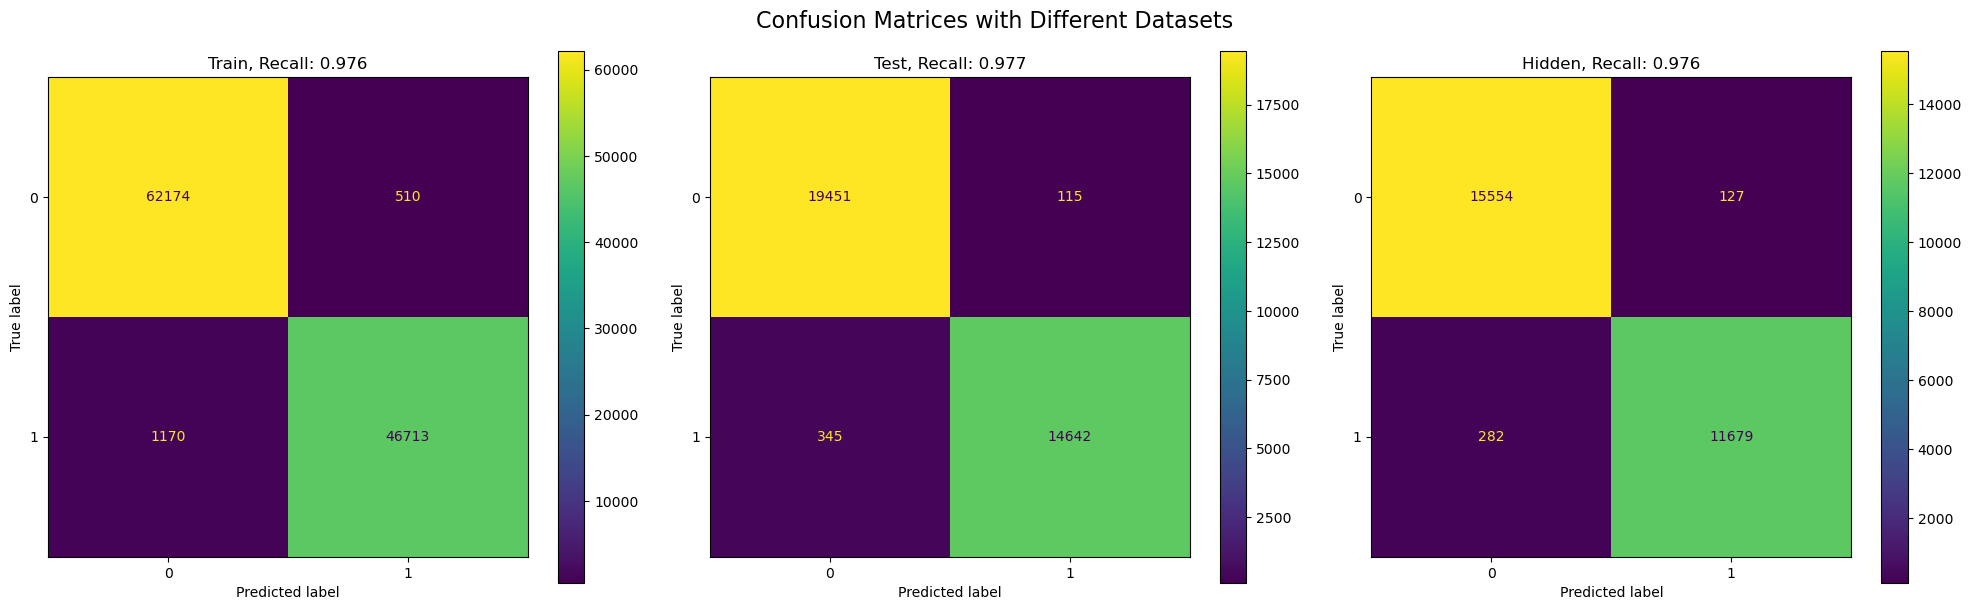

In [124]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6)) 
fig.suptitle('Confusion Matrices with Different Datasets', fontsize = 16)

# Loop through each dataset
for i, data in enumerate([[X_train, y_train, 'Train'],[X_test, y_test,'Test'], [X_hidden,y_hidden,'Hidden']]):
    y_pred = grid_svc_a.best_estimator_.predict(data[0])

    recall = recall_score(y_pred, data[1])
    
    # Generate the confusion matrix
    cm_adjusted = confusion_matrix(y_pred, data[1])
    disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm_adjusted, display_labels=grid_svc_a.best_estimator_.classes_)
    disp_cm.plot(ax=axes[i])

    # Set the title with precision score
    axes[i].set_title(f'{data[2]}, Recall: {recall:.3f}')

plt.savefig(r'C:\data\capstone\analysis\cm_comparison_svc.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

Here, it is clear that if the model predicts that OTD will not be met, then, corrective action is definitely needed. The recall for this model is excellent along with precision and AUC-ROC

In [127]:
#In the currently identified best model, let us find the permutation importance
pim_svm = permutation_importance(grid_svc_a.best_estimator_, X_hidden, y_hidden, n_repeats=10, n_jobs = -1, random_state=42, scoring='recall') #Using hidden dataset here to udnerstand impact on unseen data
for i, feature in enumerate(X_hidden.columns):
    print(f'{feature}: {pim.importances_mean[i]}')

Type: 0.0
Days for shipment (scheduled): 0.0
Benefit per order: 0.0
Customer City: 8.47026935456574e-06
Customer Country: 0.0
Customer Id: 0.0
Customer Segment: -8.47026935456574e-05
Customer State: 0.0
Department Id: 0.0
Latitude: 0.0
Longitude: 8.47026935456574e-06
Market: 0.00045739454514655
Order City: 0.00010164323225478889
Order Country: 5.0821616127394445e-05
Order Item Discount Rate: 0.0
Order Item Quantity: 0.0
Sales: 0.0
Order Region: 0.00027951888870066945
Order State: 1.694053870913148e-05
Order Status: 5.0821616127394445e-05
Shipping Mode: 0.31059630696256135
shipping_dayofweek: 0.00036422158224632686
shipping_dayofmonth: 0.49094528205996946
order_dayofweek: 0.0006352702015924305
order_month: 0.014365576825343052
order_year: 4.23513467728287e-05
order_dayofmonth: 0.48901406064712843


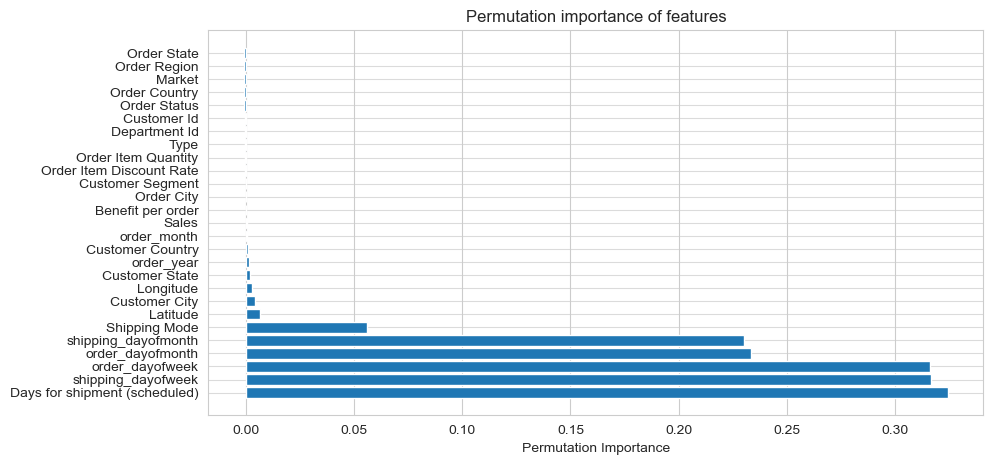

In [262]:
sorted_idx = pim_svm.importances_mean.argsort()[::-1]  # Get indices that would sort the array
importance_sorted = pim_svm.importances_mean[sorted_idx]
features_sorted = X_hidden.columns[sorted_idx]

plt.figure(figsize=(10, 5))
plt.title('Permutation importance of features')
plt.barh(features_sorted, importance_sorted)
plt.xlabel("Permutation Importance")
plt.savefig(r'C:\data\capstone\analysis\PIM_SVM.png', dpi=300, bbox_inches='tight')
plt.grid(axis='y', alpha=0.7)
plt.show()

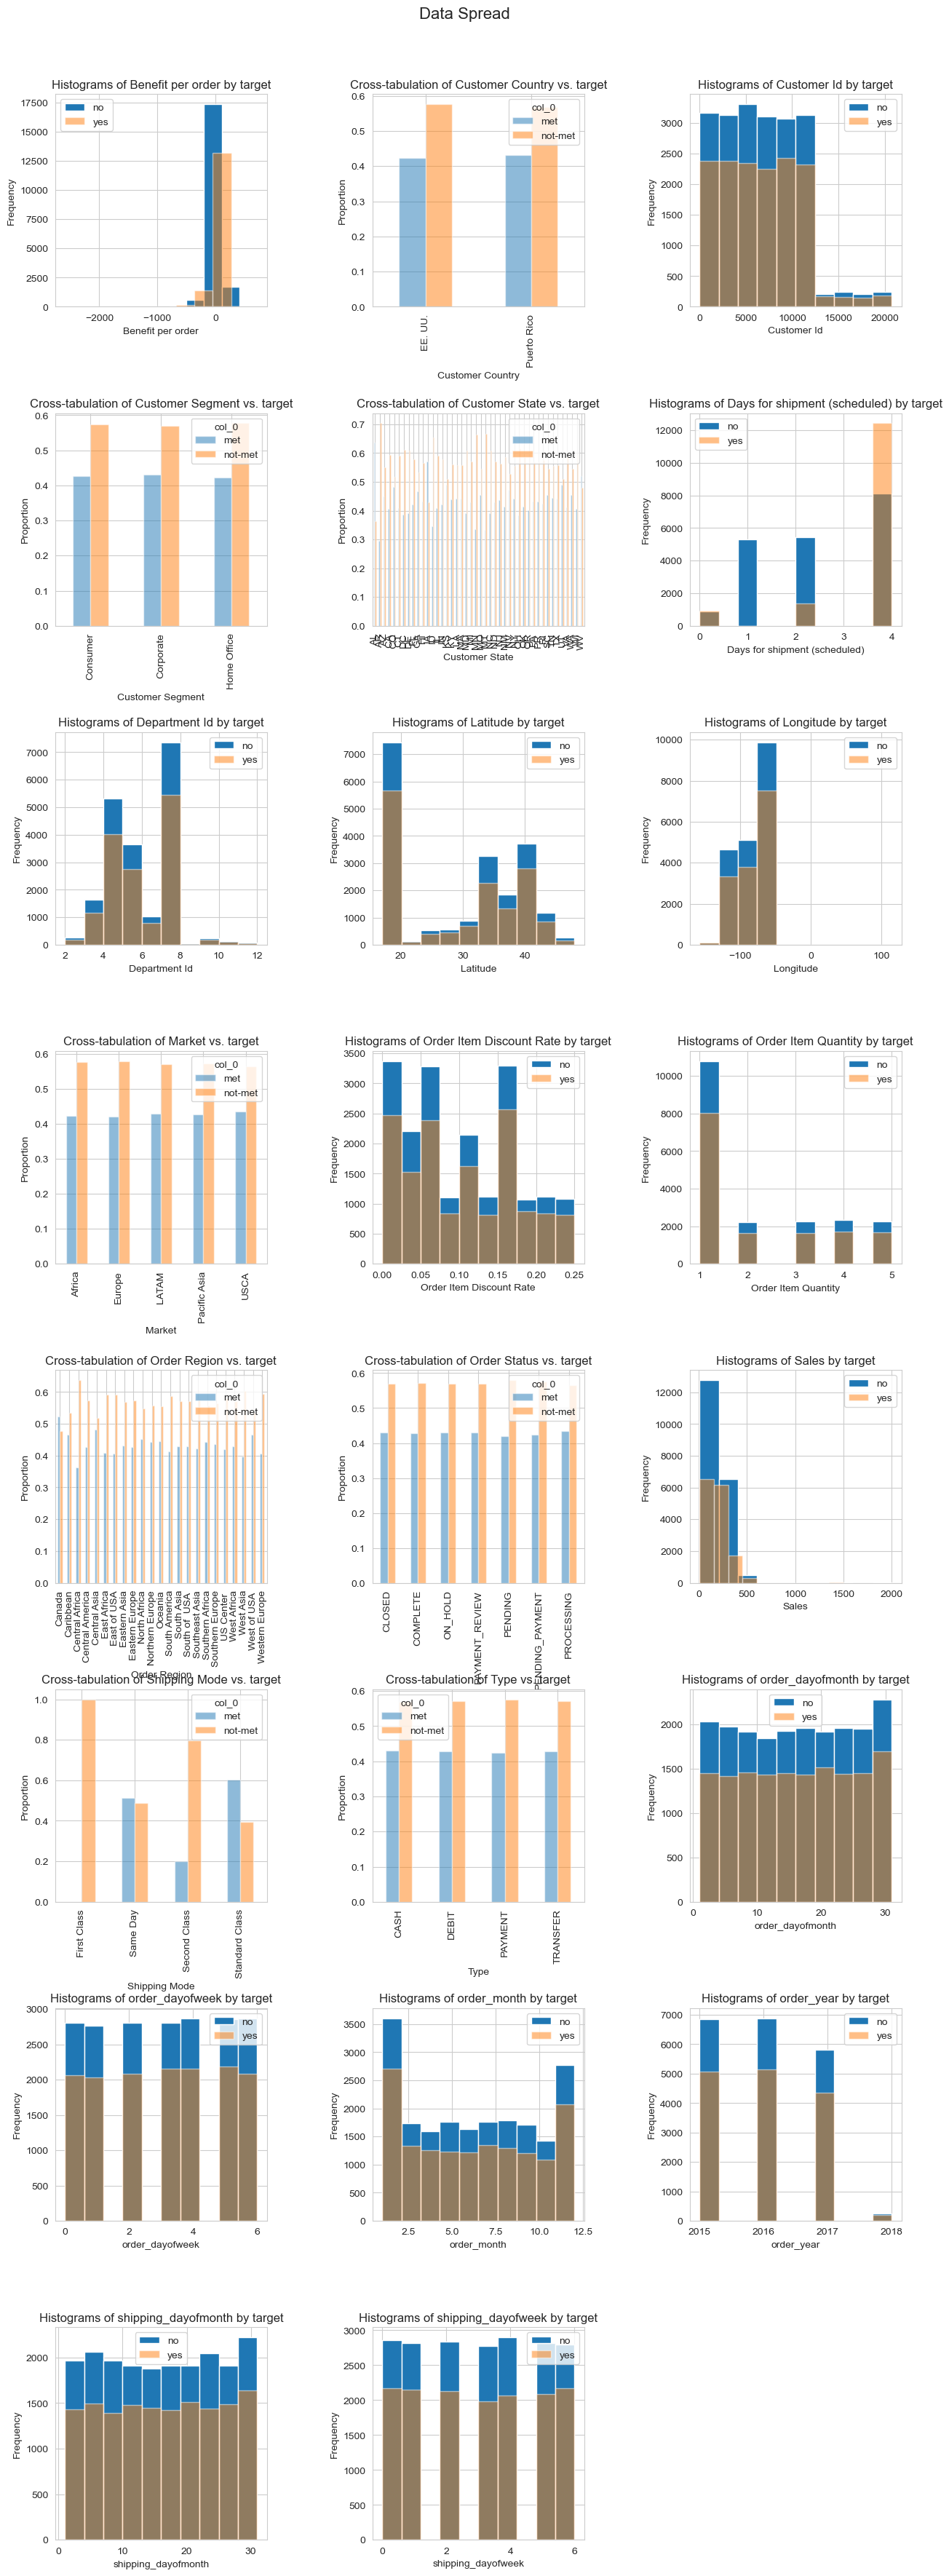

In [263]:
#Lets look at data spread
# Separate categorical and numerical features
categorical_features = X_test.select_dtypes(include=['object', 'category']).columns
categorical_features = categorical_features.difference(['Customer City', 'Order Country', 'Order City', 'Order State'])
numerical_features = X_test.select_dtypes(include=['number']).columns

# Calculate the number of rows needed for the subplots
num_rows = (len(features_sorted.difference(['Customer City', 'Order Country', 'Order City', 'Order State'])) + 2) // 3

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5 * num_rows), gridspec_kw={'top': 0.95})
plt.suptitle('Data Spread', fontsize=16)
plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.5)

axes = axes.flatten()
y_strings = np.where(y_test == 1, 'met', 'not-met')

# Loop through features and create plots
for i, feature in enumerate(features_sorted.difference(['Customer City', 'Order Country', 'Order City', 'Order State'])):
    if feature in categorical_features:
        # Categorical feature: Create cross-tabulation plot
        cross_tab = pd.crosstab(X_test[feature], y_strings, normalize='index')
        cross_tab.plot(kind='bar', stacked=False, alpha = 0.5, ax=axes[i])
        axes[i].set_title(f"Cross-tabulation of {feature} vs. target")
        axes[i].set_ylabel("Proportion")

    elif feature in numerical_features:
        # Numerical feature: Create cross-histograms with buckets
        axes[i].hist(X_test[y_test == 0][feature], alpha=1, label='no')
        axes[i].hist(X_test[y_test == 1][feature], alpha=0.5, label='yes')
        axes[i].set_title(f"Histograms of {feature} by target")
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("Frequency")
        axes[i].legend()

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.savefig(r'C:\data\capstone\analysis\Test_data_spread.png', dpi=300, bbox_inches='tight')
plt.show()

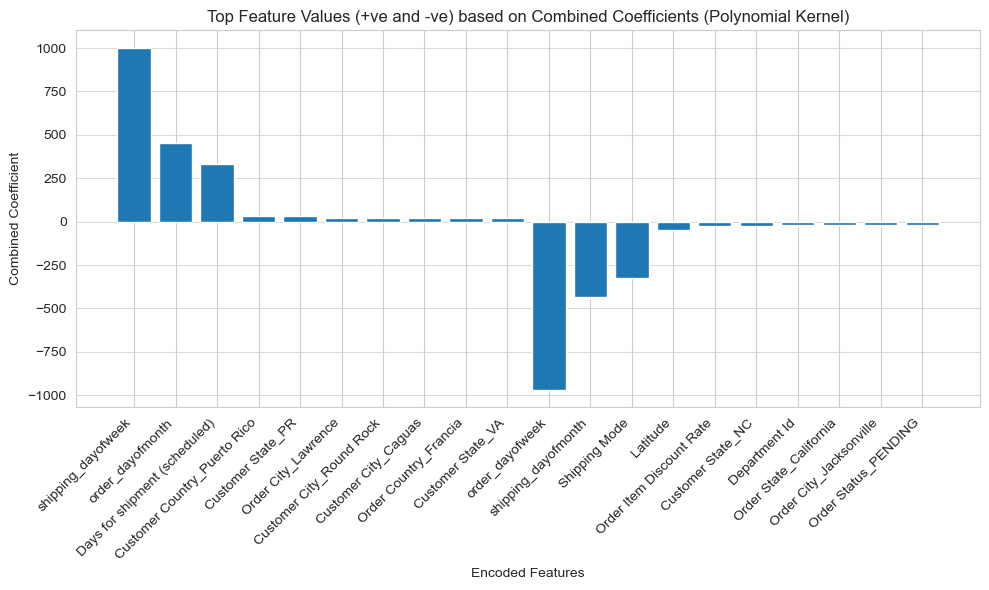

In [261]:
# Get the trained SVC model from the pipeline
pipe = grid_svc_a.best_estimator_

# Get the steps from the pipeline
encoder = pipe.named_steps['transform']
model_svm = pipe.named_steps['classifier']

# Get feature names after transforamtion
feature_names = encoder.get_feature_names_out()

# Get SVM coefficients
dual_coefficients = model_svm.dual_coef_ 
support_vectors = model_svm.support_vectors_ 
coefficients = np.dot(dual_coefficients, support_vectors) 
coefficients_dense = coefficients.toarray().ravel() 

#Readable names
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients_dense})
coef_df['Feature'] = coef_df['Feature'].apply(lambda x: x.split('_',1)[1][1:]) 


# Get top 10 positive and negative coefficients
top_positive = coef_df.nlargest(10, 'Coefficient')
top_negative = coef_df.nsmallest(10, 'Coefficient')

# Combine the top positive and negative coefficients
top_coefficients = pd.concat([top_positive, top_negative])

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(top_coefficients['Feature'], top_coefficients['Coefficient'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Encoded Features')
plt.ylabel('Combined Coefficient')
plt.title('Top Feature Values (+ve and -ve) based on Combined Coefficients (Polynomial Kernel)')
plt.grid(axis='y', alpha=0.7)
plt.tight_layout()

plt.savefig(r'C:\data\capstone\analysis\individual_feature_values.png', dpi=300, bbox_inches='tight')

plt.show()

### Ensemble model

Ensemble models are expected to have better results than standalone modesl. As DTree had pretty good numbers earlier, we will try both bagging and boosting methonds using it to generate models with better features

Lets try four approaches. 
1. Bagging using Random Forest
2. Boosting using ADABoost
3. Boosting using GradientBoost
3. Boosting using XGBoost

In [51]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import plot_tree
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

In [52]:
#Creating Parameter sets for SKlearn based models
# Random Forest parameters
params_rf = {
    'classifier__n_estimators': [100,200,300,500],
    'classifier__max_depth': [10,20,30,50,100],
    'classifier__max_features': ['log2', 'sqrt'],
    'classifier__ccp_alpha': [0.0, 0.01, 0.02]
}

# AdaBoost parameters
params_ada = {
    'classifier__n_estimators': [50, 100, 200,500],
    'classifier__learning_rate': [0.01, 0.1, 1.0]
}

# Gradient Boosting parameters
params_gb = {
    'classifier__n_estimators': [50, 100, 200,500],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 1.0],
}

#XGBoost
params_xgb = {
    'classifier__n_estimators': [50, 100, 200,500],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 1.0],
}

In [53]:
grid_rf_full = GridSearch_and_score('Random Forest - Tuned for Recall', params_rf, RandomForestClassifier(random_state=42),  'recall')
print('Best Param:' + str(grid_rf_full.best_params_))

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best Param:{'classifier__ccp_alpha': 0.0, 'classifier__max_depth': 100, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 500}


In [54]:
grid_ada_full = GridSearch_and_score('ADA - Tuned for Recall', params_ada, AdaBoostClassifier(random_state=42),  'recall')
print('Best Param:' + str(grid_ada_full.best_params_))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Param:{'classifier__learning_rate': 1.0, 'classifier__n_estimators': 50}


In [55]:
grid_gb_full = GridSearch_and_score('Gradient Boosting - Tuned for Recall', params_gb, GradientBoostingClassifier(random_state=42),  'recall')
print('Best Param:' + str(grid_gb_full.best_params_))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Param:{'classifier__learning_rate': 1.0, 'classifier__n_estimators': 500}


In [56]:
grid_xgb_full = GridSearch_and_score('XGBoost - Tuned for Recall', params_xgb, xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='auc'),  'recall')
print('Best Param:' + str(grid_xgb_full.best_params_))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Param:{'classifier__learning_rate': 0.1, 'classifier__n_estimators': 500}


In [57]:
df_grid_ens = pd.DataFrame({'model': type_of_model, 'params' : param_values, 'train Recall':train_score_recall, 'train AUC-ROC':train_score_aoc, 'train Precision':train_score_prec,'test Recall':test_score_recall,'test AUC-ROC':test_score_aoc, 'test Precision':test_score_prec, 'fit time': fit_time, 'score time':score_time })

df_grid_ens.set_index('model', inplace=True)
df_grid_ens['params'] = df_grid_ens['params'].astype(str)
pd.options.display.max_colwidth = None
df_grid_ens

params  \
model                                                                                                                                                                                                                                                          
Logistics Regression - Default                                                                                                                                                                                                                            {}   
KNN - Default                                                                                                                                                                                                                                             {}   
DTree - Default                                                                                                                                                                                                                                           {}   
SVC - Default                                                                                                                                                                                                                                             {}   
Logistics Regression - Tuned for Recall                                                                                      {'classifier__C': 0.01, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}   
KNN - Tuned for Recall                                                                                             {'classifier__algorithm': 'kd_tree', 'classifier__metric': 'manhattan', 'classifier__n_neighbors': 31, 'classifier__weights': 'distance'}   
DTree - Tuned for Recall                 {'classifier__class_weight': 'balanced', 'classifier__criterion': 'entropy', 'classifier__max_depth': 100, 'classifier__max_features': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5}   
SVC - Tuned for Recall                                                                                                                            {'classifier__C': 10, 'classifier__degree': 3, 'classifier__gamma': 'scale', 'classifier__kernel': 'poly'}   
DTree - Tuned for Recall - Full dataset   {'classifier__class_weight': 'balanced', 'classifier__criterion': 'entropy', 'classifier__max_depth': 30, 'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}   
Random Forest - Tuned for Recall                                                                                           {'classifier__ccp_alpha': 0.0, 'classifier__max_depth': 100, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 500}   
ADA - Tuned for Recall                                                                                                                                                                    {'classifier__learning_rate': 1.0, 'classifier__n_estimators': 50}   
Gradient Boosting - Tuned for Recall                                                                                                                                                     {'classifier__learning_rate': 1.0, 'classifier__n_estimators': 500}   
XGBoost - Tuned for Recall                                                                                                                                                               {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 500}   

                                         train Recall  train AUC-ROC  \
model                                                                  
Logistics Regression - Default               0.843510       0.771839   
KNN - Default                                0.921665       0.904294   
DTree - Default                              1.000000       1.000000   
SVC - Default                                

In [58]:
# Grandient Boost and XGBoost are turning out perfect scores accross the board. This indicated overfitting. Trying to reduce the complexity of the models now
# Gradient Boosting parameters
params_gb_lc = {
    'classifier__n_estimators': [50, 100],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 1.0],
}

#XGBoost
params_xgb_lc = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.001, 0.01, 0.2],
    'classifier__max_depth': [1, 3, 5]
}

In [59]:
grid_gb_full_lc = GridSearch_and_score('Gradient Boosting - Lower Complexity', params_gb_lc, GradientBoostingClassifier(random_state=42),  'recall')
print('Best Param:' + str(grid_gb_full_lc.best_params_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Param:{'classifier__learning_rate': 1.0, 'classifier__n_estimators': 100}


In [60]:
grid_xgb_full_lc = GridSearch_and_score('XGBoost - Lower Complexity', params_xgb_lc, xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='auc'),  'recall')
print('Best Param:' + str(grid_xgb_full_lc.best_params_))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Param:{'classifier__learning_rate': 0.2, 'classifier__max_depth': 5, 'classifier__n_estimators': 200}


In [61]:
df_grid_ens_lc = pd.DataFrame({'model': type_of_model, 
                               'params' : param_values, 
                               'train Recall':train_score_recall, 
                               'train AUC-ROC':train_score_aoc, 
                               'train Precision':train_score_prec,
                               'test Recall':test_score_recall,
                               'test AUC-ROC':test_score_aoc, 
                               'test Precision':test_score_prec, 
                               'fit time': fit_time, 
                               'score time':score_time })

df_grid_ens_lc.set_index('model', inplace=True)
pd.options.display.max_colwidth = None
df_grid_ens_lc

params  \
model                                                                                                                                                                                                                                                          
Logistics Regression - Default                                                                                                                                                                                                                            {}   
KNN - Default                                                                                                                                                                                                                                             {}   
DTree - Default                                                                                                                                                                                                                                           {}   
SVC - Default                                                                                                                                                                                                                                             {}   
Logistics Regression - Tuned for Recall                                                                                      {'classifier__C': 0.01, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}   
KNN - Tuned for Recall                                                                                             {'classifier__algorithm': 'kd_tree', 'classifier__metric': 'manhattan', 'classifier__n_neighbors': 31, 'classifier__weights': 'distance'}   
DTree - Tuned for Recall                 {'classifier__class_weight': 'balanced', 'classifier__criterion': 'entropy', 'classifier__max_depth': 100, 'classifier__max_features': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5}   
SVC - Tuned for Recall                                                                                                                            {'classifier__C': 10, 'classifier__degree': 3, 'classifier__gamma': 'scale', 'classifier__kernel': 'poly'}   
DTree - Tuned for Recall - Full dataset   {'classifier__class_weight': 'balanced', 'classifier__criterion': 'entropy', 'classifier__max_depth': 30, 'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}   
Random Forest - Tuned for Recall                                                                                           {'classifier__ccp_alpha': 0.0, 'classifier__max_depth': 100, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 500}   
ADA - Tuned for Recall                                                                                                                                                                    {'classifier__learning_rate': 1.0, 'classifier__n_estimators': 50}   
Gradient Boosting - Tuned for Recall                                                                                                                                                     {'classifier__learning_rate': 1.0, 'classifier__n_estimators': 500}   
XGBoost - Tuned for Recall                                                                                                                                                               {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 500}   
Gradient Boosting - Lower Complexity                                                                                                                                                     {'classifier__learning_rate': 1.0, 'classifier__n_estimators': 100}   
XGBoost - Lower Complexity                                                                                                                            

#### With this, the lower complexity XGBoost looks like a much better option that even the tuned SVC. The Gradient Boosting model is still overfitting. Choosing the lower complexity XGBosot model as the final model 

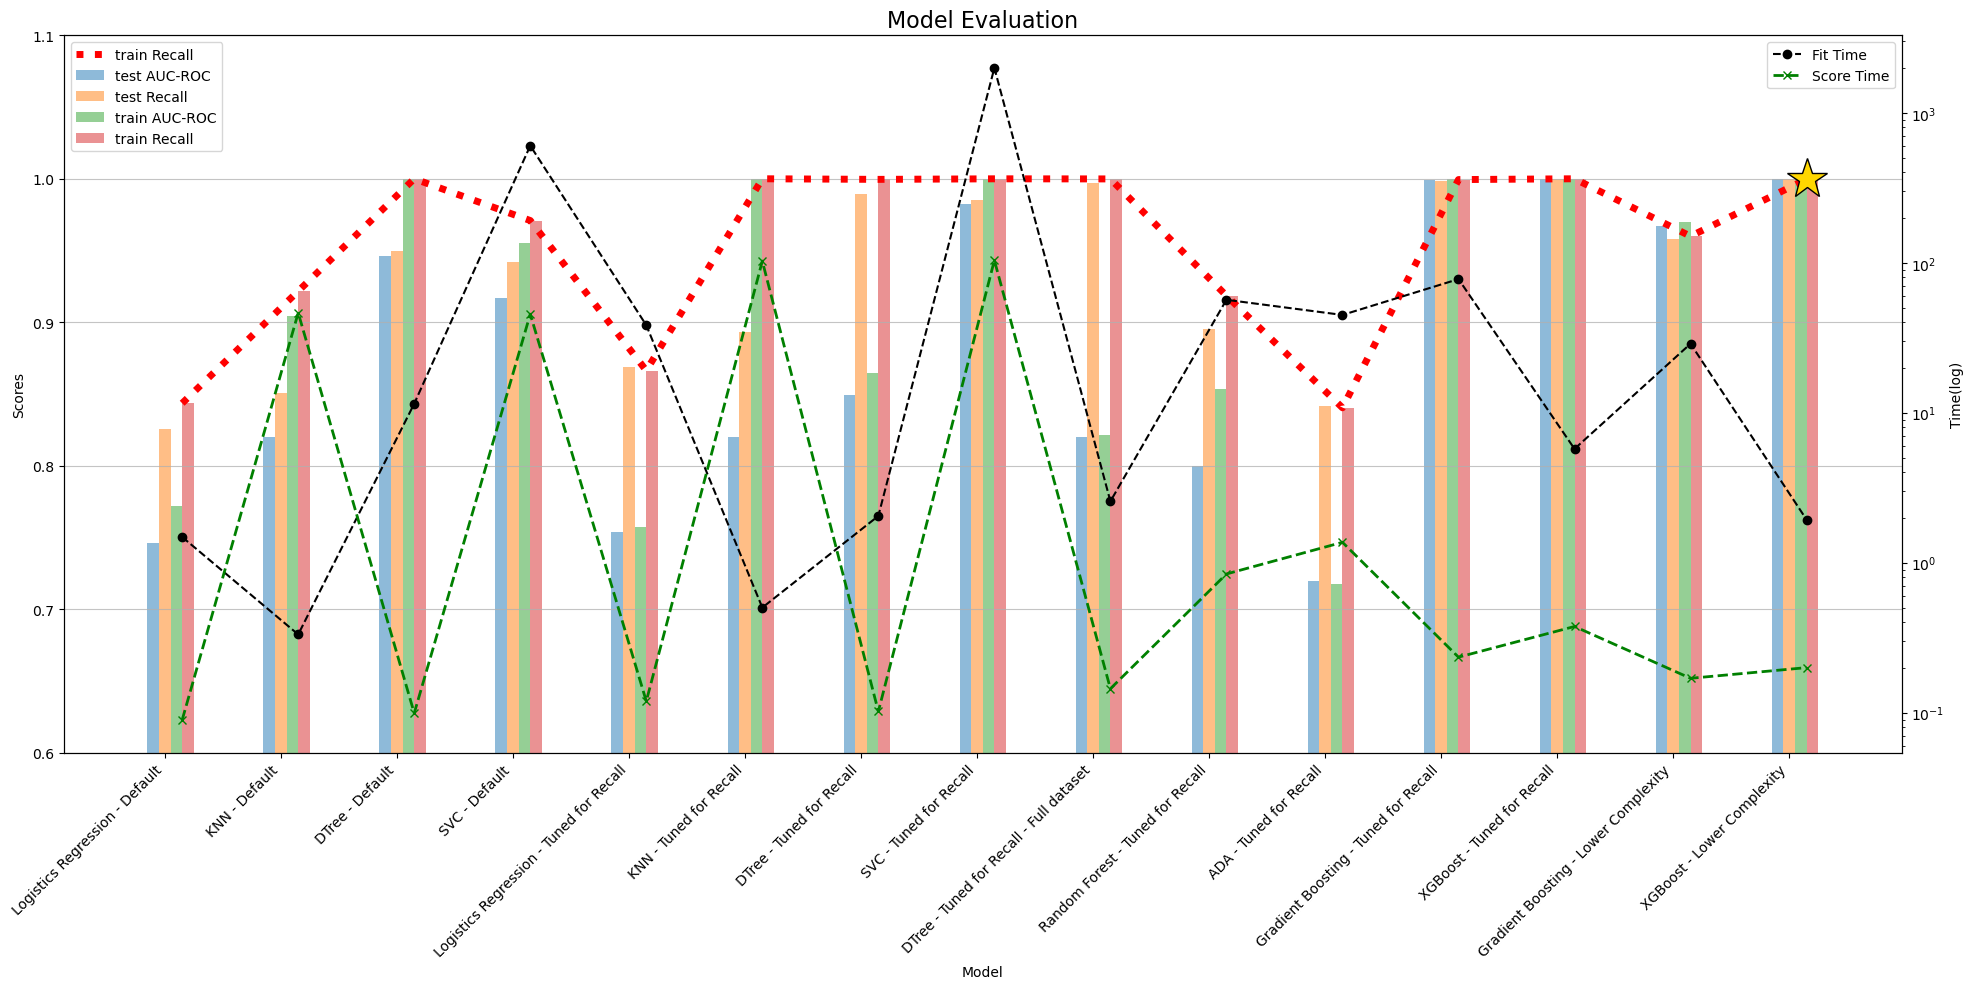

In [211]:
#Visualizing all
# Create the figure and axes
fig, ax = plt.subplots(figsize=(20, 10))

# Bar width and positions
bar_width = 0.1
index = np.arange(len(df_grid_ens_lc))

# Plot the bars for each column
for i, col in enumerate(df_grid_ens_lc.columns.difference(['params', 'test Precision', 'train Precision', 'model', 'fit time', 'score time'])):
    ax.bar(index + i * bar_width, df_grid_ens_lc[col], bar_width, label=col, alpha=0.5)

#one line to track the train Recall
ax.plot(index + 2.5 * bar_width, df_grid_ens_lc['train Recall'], color='red', linewidth=5, linestyle=':', label='train Recall')

# Set labels, title, and legend
ax.set_xlabel('Model')
ax.set_ylabel('Scores')
ax.set_title('Model Evaluation',fontsize = 16)
ax.set_xticks(index + bar_width)  # Center the x-axis labels
ax.set_xticklabels(df_grid_ens_lc.index, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0.6, 1.1)
ax.grid(axis='y', alpha=0.75)
ax.legend(loc = 'upper left')

ax2 = ax.twinx()
ax2.plot(index + 2.5 * bar_width, df_grid_ens_lc['fit time'], color='black', marker='o', linestyle='--', label='Fit Time')
ax2.plot(index + 2.5 * bar_width, df_grid_ens_lc['score time'], color='green', linewidth=2, linestyle='--', marker='x', label='Score Time')
ax2.set_ylabel('Time(log)') 
ax2.tick_params(axis='y')
ax2.set_yscale('log')
ax2.legend(loc = 'upper right')

# Add a marker for the best model
ax.plot(14 + 2.5 * bar_width, df_grid_ens_lc['test Recall'].max(), marker='*', markersize=30, color='gold', markeredgecolor='black', linestyle='', label='Best Model', alpha = 1)

plt.tight_layout()
plt.savefig(r'C:\data\capstone\analysis\model_evaluation_final.png', dpi=300, bbox_inches='tight')
plt.show()

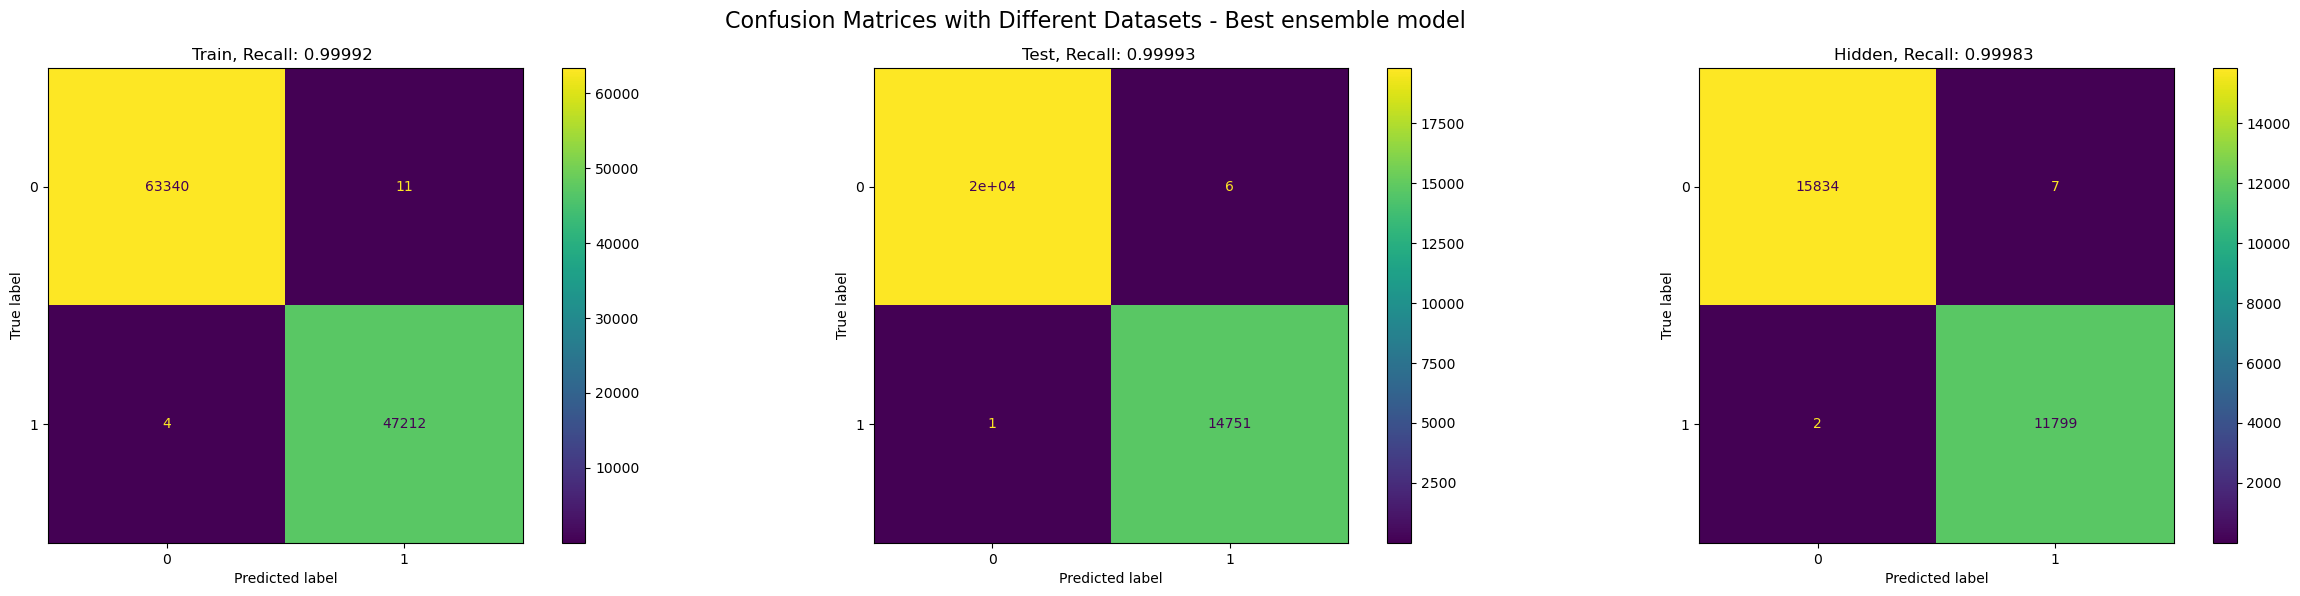

In [83]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 6)) 
fig.suptitle('Confusion Matrices with Different Datasets - Best ensemble model', fontsize = 16)

# Loop through each dataset
for i, data in enumerate([[X_train, y_train, 'Train'],[X_test, y_test,'Test'], [X_hidden,y_hidden,'Hidden']]):
    y_pred = grid_xgb_full_lc.best_estimator_.predict(data[0])

    recall = recall_score(y_pred, data[1])
    
    # Generate the confusion matrix
    cm_adjusted = confusion_matrix(y_pred, data[1])
    disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm_adjusted, display_labels=grid_xgb_full_lc.best_estimator_.classes_)
    disp_cm.plot(ax=axes[i])

    # Set the title 
    axes[i].set_title(f'{data[2]}, Recall: {recall:.5f} ')

plt.savefig(r'C:\data\capstone\analysis\cm_comparison_ens_Best.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [81]:
#Identify feature importance
pim = permutation_importance(grid_xgb_full_lc.best_estimator_, X_hidden, y_hidden, n_repeats=10, n_jobs = -1, random_state=42, scoring='recall') #Using hidden dataset here to udnerstand impact on unseen data
for i, feature in enumerate(X_hidden.columns):
    print(f'{feature}: {pim.importances_mean[i]}')
sorted_idx = pim.importances_mean.argsort()[::-1]  # Get indices that would sort the array
importance_sorted = pim.importances_mean[sorted_idx]
features_sorted = X_hidden.columns[sorted_idx]

Type: 0.0
Days for shipment (scheduled): 0.0
Benefit per order: 0.0
Customer City: 8.47026935456574e-06
Customer Country: 0.0
Customer Id: 0.0
Customer Segment: -8.47026935456574e-05
Customer State: 0.0
Department Id: 0.0
Latitude: 0.0
Longitude: 8.47026935456574e-06
Market: 0.00045739454514655
Order City: 0.00010164323225478889
Order Country: 5.0821616127394445e-05
Order Item Discount Rate: 0.0
Order Item Quantity: 0.0
Sales: 0.0
Order Region: 0.00027951888870066945
Order State: 1.694053870913148e-05
Order Status: 5.0821616127394445e-05
Shipping Mode: 0.31059630696256135
shipping_dayofweek: 0.00036422158224632686
shipping_dayofmonth: 0.49094528205996946
order_dayofweek: 0.0006352702015924305
order_month: 0.014365576825343052
order_year: 4.23513467728287e-05
order_dayofmonth: 0.48901406064712843


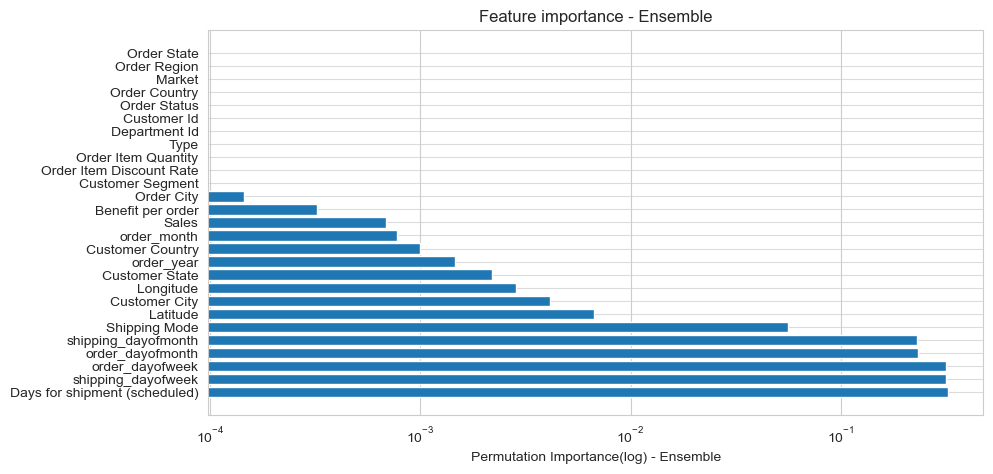

In [264]:
plt.figure(figsize=(10, 5))
plt.title('Feature importance - Ensemble')
plt.barh(features_sorted, importance_sorted)
plt.xscale('log')
plt.xlabel("Permutation Importance(log) - Ensemble")
plt.grid(axis='y', alpha=0.7)
plt.savefig(r'C:\data\capstone\analysis\PIM_ens.png', dpi=300, bbox_inches='tight')
plt.show()

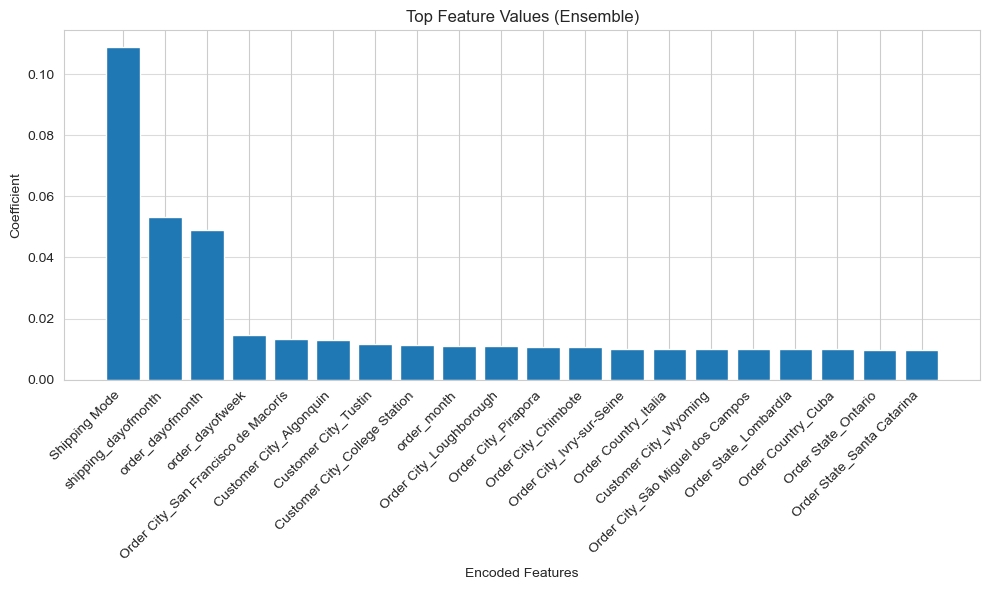

In [265]:
# Get important feature values
# Get the trained ensemble model from the pipeline
pipe = grid_xgb_full_lc.best_estimator_

# Get the steps from the pipeline
encoder = pipe.named_steps['transform']
model_xgb = pipe.named_steps['classifier']

# Get feature names after transforamtion
feature_names = encoder.get_feature_names_out()

# Get XGB coefficients
coefficients = model_xgb.feature_importances_ 

#Readable names
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df['Feature'] = coef_df['Feature'].apply(lambda x: x.split('_',1)[1][1:]) 


# Get top 10 positive and negative coefficients
top_positive = coef_df[coef_df['Coefficient'] > 0].nlargest(20, 'Coefficient')
top_negative = coef_df[coef_df['Coefficient'] < 0].nsmallest(10, 'Coefficient')

# Combine the top positive and negative coefficielnts
top_coefficients = pd.concat([top_positive, top_negative])

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(top_coefficients['Feature'], top_coefficients['Coefficient'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Encoded Features')
plt.ylabel('Coefficient')
plt.title('Top Feature Values (Ensemble)')
plt.grid(axis='y', alpha=0.7)
plt.tight_layout()

plt.savefig(r'C:\data\capstone\analysis\individual_feature_values_ensemble.png', dpi=300, bbox_inches='tight')

plt.show()

In [65]:
top_coefficients

Feature  Coefficient
0                           Shipping Mode     0.108855
5431                  shipping_dayofmonth     0.053092
5435                     order_dayofmonth     0.049131
5432                      order_dayofweek     0.014557
3378  Order City_San Francisco de Macorís     0.013377
5                 Customer City_Algonquin     0.013032
511                  Customer City_Tustin     0.011673
102         Customer City_College Station     0.011208
5433                          order_month     0.011158
2464              Order City_Loughborough     0.010867
3068                  Order City_Pirapora     0.010662
1303                  Order City_Chimbote     0.010591
2065            Order City_Ivry-sur-Seine     0.010154
4227                 Order Country_Italia     0.010117
556                 Customer City_Wyoming     0.010113
3642     Order City_São Miguel dos Campos     0.010059
4920                Order State_Lombardía     0.010045
4190                   Order Country_Cuba     0.010015
5091                  Order State_Ontario     0.009706
5213           Order State_Santa Catarina     0.009612

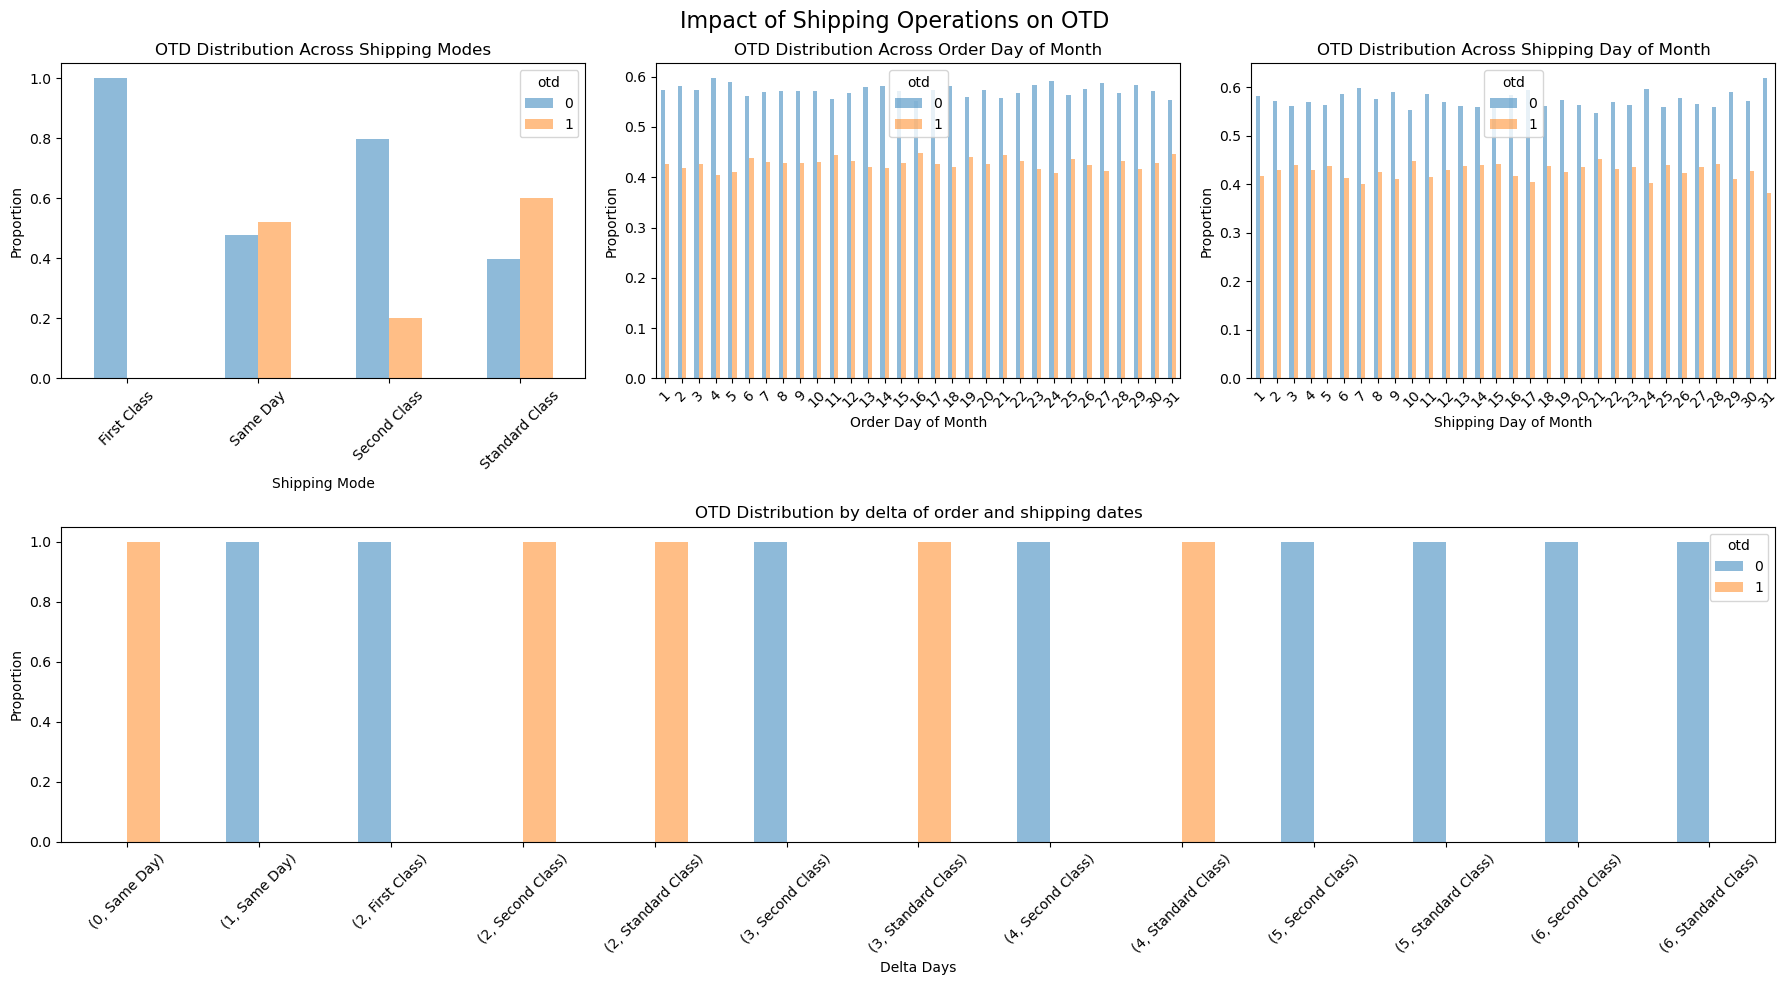

In [66]:
#Now, lets plot these
fig, axes = plt.subplots(2, 3, figsize=(18, 10), gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [1, 1, 1]})

plt.suptitle('Impact of Shipping Operations on OTD', fontsize = 16)

cross_tab1 = pd.crosstab(data_class['Shipping Mode'],data_class['otd'] , normalize='index')
cross_tab1.plot(kind='bar', stacked=False, alpha = 0.5, ax=axes[0][0])
axes[0][0].set_title('OTD Distribution Across Shipping Modes')
axes[0][0].set_xlabel('Shipping Mode')
axes[0][0].set_ylabel('Proportion')
axes[0][0].tick_params(axis='x', rotation=45) 

cross_tab2 = pd.crosstab(data_class['order_dayofmonth'],data_class['otd'] , normalize='index')
cross_tab2.plot(kind='bar', stacked=False, alpha = 0.5, ax=axes[0][1])
axes[0][1].set_title('OTD Distribution Across Order Day of Month')
axes[0][1].set_xlabel('Order Day of Month')
axes[0][1].set_ylabel('Proportion')
axes[0][1].tick_params(axis='x', rotation=45) 

cross_tab3 = pd.crosstab(data_class['shipping_dayofmonth'],data_class['otd'] , normalize='index')
cross_tab3.plot(kind='bar', stacked=False, alpha = 0.5, ax=axes[0][2])
axes[0][2].set_title('OTD Distribution Across Shipping Day of Month')
axes[0][2].set_xlabel('Shipping Day of Month')
axes[0][2].set_ylabel('Proportion')
axes[0][2].tick_params(axis='x', rotation=45) 

gs = axes[1, 0].get_gridspec()
for ax in axes[1, :]:
    ax.remove()
axbig = fig.add_subplot(gs[1, :]) 

#Lets check if the gap between ordering and Shipping dates plays a role
df_ship_delta = X_rationalized.copy()
df_ship_delta['order_date'] = pd.to_datetime(df_ship_delta['order_year'].astype(str) + '-' + df_ship_delta['order_month'].astype(str) + '-' + df_ship_delta['order_dayofmonth'].astype(str))
df_ship_delta['shipping_date'] = pd.to_datetime(df_ship_delta['shipping_year'].astype(str) + '-' + df_ship_delta['shipping_month'].astype(str) + '-' + df_ship_delta['shipping_dayofmonth'].astype(str))
df_ship_delta['days_difference'] = (df_ship_delta['shipping_date'] - df_ship_delta['order_date']).dt.days

cross_tab4 = pd.crosstab([df_ship_delta['days_difference'],df_ship_delta['Shipping Mode']],df_ship_delta['otd'] , normalize='index')
cross_tab4.plot(kind='bar', stacked=False, alpha = 0.5, ax=axbig, width = 0.5)
axbig.set_title('OTD Distribution by delta of order and shipping dates')
axbig.set_xlabel('Delta Days')
axbig.set_ylabel('Proportion')
axbig.tick_params(axis='x', rotation=45) 


plt.tight_layout()
plt.savefig(r'C:\data\capstone\analysis\impact_of_shipping_op_on_ensemble.png', dpi=300, bbox_inches='tight')
plt.show()

In [67]:
#plot a chart to show the percentage of otd misses for these order and customer states
df_cust_cities = data_class[data_class['Customer City'].isin(['Fairfield', 'Algonquin', 'Stockton'])][['Customer City','otd']]
df_ord_cities = data_class[data_class['Order City'].isin(['Lyon', 'Loughborough', 'Apopa', 'San Francisco de Macorís','Villahermosa','Recife','Villeurbanne','Pirapora'])][['Order City','otd']]
df_ord_states =  data_class[data_class['Order State'].isin(['Michigan', 'Tamaulipas', 'Lombardía'])][['Order State','otd']]

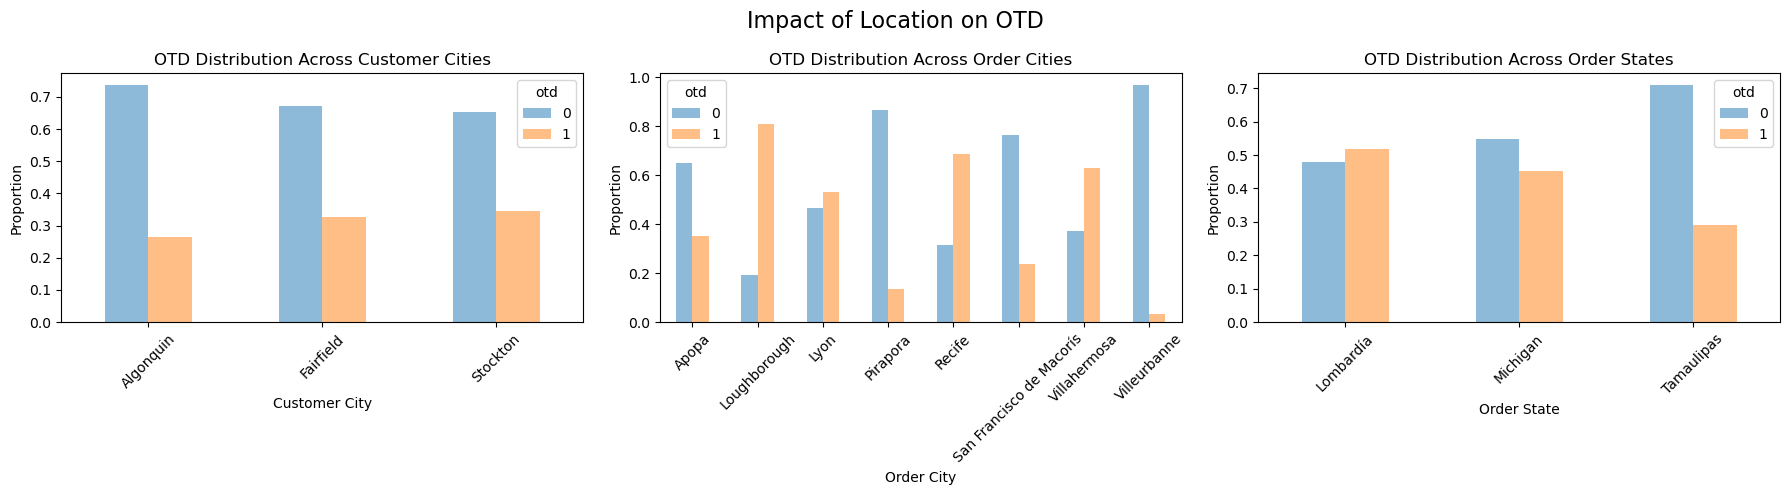

In [68]:
#Now, lets plot these
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

plt.suptitle('Impact of Location on OTD', fontsize = 16)

cross_tab1 = pd.crosstab(df_cust_cities['Customer City'],df_cust_cities['otd'] , normalize='index')
cross_tab1.plot(kind='bar', stacked=False, alpha = 0.5, ax=axes[0])
axes[0].set_title('OTD Distribution Across Customer Cities')
axes[0].set_xlabel('Customer City')
axes[0].set_ylabel('Proportion')
axes[0].tick_params(axis='x', rotation=45) 

cross_tab2 = pd.crosstab(df_ord_cities['Order City'],df_ord_cities['otd'] , normalize='index')
cross_tab2.plot(kind='bar', stacked=False, alpha = 0.5, ax=axes[1])
axes[1].set_title('OTD Distribution Across Order Cities')
axes[1].set_xlabel('Order City')
axes[1].set_ylabel('Proportion')
axes[1].tick_params(axis='x', rotation=45) 

cross_tab3 = pd.crosstab(df_ord_states['Order State'],df_ord_states['otd'] , normalize='index')
cross_tab3.plot(kind='bar', stacked=False, alpha = 0.5, ax=axes[2])
axes[2].set_title('OTD Distribution Across Order States')
axes[2].set_xlabel('Order State')
axes[2].set_ylabel('Proportion')
axes[2].tick_params(axis='x', rotation=45) 

plt.tight_layout()
plt.savefig(r'C:\data\capstone\analysis\impact_of_loaction_on_ensemble.png', dpi=300, bbox_inches='tight')
plt.show()

#### Final Productionalization

In [69]:
import joblib

In [70]:
best_model = grid_xgb_full_lc

In [71]:
#Save the model
joblib.dump(best_model, r'C:\data\capstone\analysis\otd_classifier.model')

['C:\\data\\capstone\\analysis\\otd_classifier.model']

In [72]:
#Laod the model back
loaded_model = joblib.load(r'C:\data\capstone\analysis\otd_classifier.model')
loaded_model

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise',
             estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(categories=[['Second '
                                                                                                     'Class',
                                                                                                     'Standard '
                                                                                                     'Class',
                                                                                                     'First '
                                                                                                     'Class',
                                                                                                     'Same '
                                                                                                     'Day']],
                                                                                        handle_unknown='use_encoded_value',
                                                                                        unknown_value=-...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=40,
             param_grid={'classifier__learning_rate': [0.001, 0.01, 0.2],
                         'classifier__max_depth': [1, 3, 5],
                         'classifier__n_estimators': [50, 100, 200]},
             scoring='recall', verbose=2)

In [73]:
def predict_otd(model, input_data):
    """
    Will this order be delivered in time?

    Parameters:
    - model: Tuend  model
    - input_data: DataFrame containing the input features for the new data

    Returns:
    - predicted_values: Yes/No
    """
    predictions = model.predict(input_data)

    return np.where(predictions == 1, 'met', 'not-met')

In [74]:
#This could be read in from a CSV or even used via an API as described lated on
new_order_data = {
    'Type': ['CASH', 'TRANSFER'],
    'Days for shipment (scheduled)': [5, 3],
    'Benefit per order': [10000, 5000],
    'Customer City': ['Los Angeles', 'San Francisco'],
    'Customer Country': ['EE.UU.', 'EE.UU'],
    'Customer Id': [11231234, 54321123],
    'Customer Segment': ['Consumer', 'Corporate'],
    'Customer State': ['CA', 'NY'],
    'Department Id': [5, 7],
    'Latitude': [40, 35],
    'Longitude': [-100, -120],
    'Market': ['USCA', 'Europe'],
    'Order City': ['Los Angeles', 'Chicago'],
    'Order Country': ['Estados Unidos', 'Alemania'],
    'Order Item Discount Rate': [1.5, 0.8],
    'Order Item Quantity': [5, 2],
    'Sales': [5000, 2000],
    'Order Region': ['West of USA', 'Central America'],
    'Order State': ['California', 'Illinois'],
    'Order Status': ['COMPLETE', 'PENDING'],
    'Shipping Mode': ['First Class', 'Second Class'],
    'shipping_dayofweek': [5, 2],
    'shipping_dayofmonth': [5, 10],
    'order_dayofweek': [5, 1],
    'order_month': [5, 10],
    'order_year': [2018, 2020],
    'order_dayofmonth': [5, 20]
}

new_order_df = pd.DataFrame(new_order_data)
new_order_df

Type  Days for shipment (scheduled)  Benefit per order  Customer City  \
0      CASH                              5              10000    Los Angeles   
1  TRANSFER                              3               5000  San Francisco   

  Customer Country  Customer Id Customer Segment Customer State  \
0           EE.UU.     11231234         Consumer             CA   
1            EE.UU     54321123        Corporate             NY   

   Department Id  Latitude  ...     Order Region Order State Order Status  \
0              5        40  ...      West of USA  California     COMPLETE   
1              7        35  ...  Central America    Illinois      PENDING   

  Shipping Mode  shipping_dayofweek  shipping_dayofmonth  order_dayofweek  \
0   First Class                   5                    5                5   
1  Second Class                   2                   10                1   

  order_month order_year order_dayofmonth  
0           5       2018                5  
1          10       2020               20  

[2 rows x 27 columns]

In [75]:
prediction = predict_otd(model = loaded_model, input_data=new_order_df)
new_order_df['prediction'] = prediction
new_order_df

Type  Days for shipment (scheduled)  Benefit per order  Customer City  \
0      CASH                              5              10000    Los Angeles   
1  TRANSFER                              3               5000  San Francisco   

  Customer Country  Customer Id Customer Segment Customer State  \
0           EE.UU.     11231234         Consumer             CA   
1            EE.UU     54321123        Corporate             NY   

   Department Id  Latitude  ...  Order State Order Status Shipping Mode  \
0              5        40  ...   California     COMPLETE   First Class   
1              7        35  ...     Illinois      PENDING  Second Class   

  shipping_dayofweek  shipping_dayofmonth  order_dayofweek  order_month  \
0                  5                    5                5            5   
1                  2                   10                1           10   

  order_year order_dayofmonth prediction  
0       2018                5    not-met  
1       2020               20        met  

[2 rows x 28 columns]

### API

In [76]:
from fastapi import FastAPI
from pydantic import BaseModel #Help define the format
import pandas as pd
import joblib
import numpy as np

class order (BaseModel):
    type: str
    days_for_shipment_scheduled: int
    benefit_per_order: int
    customer_city: str
    customer_country: str
    customer_id: int
    customer_segment: str
    customer_state: str
    department_id: int
    latitude: int
    longitude: int
    market: str
    order_city: str
    order_country: str
    order_item_discount_rate: int
    order_item_quantity: int
    sales: int
    order_region: str
    order_state: str
    order_status: str
    shipping_mode: str
    shipping_dayofweek: int
    shipping_dayofmonth: int
    order_dayofweek: int
    order_month: int
    order_year: int
    order_dayofmonth: int
    

app = FastAPI()

@app.post('/predict')
def predict_otd(order: order):
    #print order to the console
    print(order)
    loaded_model = joblib.load('<Path>\otd_classifer.model')
    order_dict = order.dict()
    input_data = pd.DataFrame([order_dict])
    prediction = loaded_model.predict(input_data)
    #print prediction to console
    print(prediction)
    return str(np.where(prediction == 1, 'yes', 'no')[0])

#### To test:

##### Not-Met
{
    "type": "CASH",
    "days_for_shipment_(scheduled)": 5,
    "benefit_per_order": 10000,
    "customer_city": "Los Angeles",
    "customer_country": "EE.UU.",
    "customer_id": 11231234,
    "customer_segment": "Consumer",
    "customer_state": "CA",
    "department_id": 5,
    "latitude": 40,
    "longitude": -100,
    "market": "USCA",
    "order_city": "Los Angeles",
    "order_country": "Estados Unidos",
    "order_item_discount_rate": 1.5,
    "order_item_quantity": 5,
    "sales": 5000,
    "order_region": "West of USA",
    "order_state": "California",
    "order_status": "COMPLETE",
    "shipping_mode": "First Class",
    "shipping_dayofweek": 5,
    "shipping_dayofmonth": 5,
    "order_dayofweek": 5,
    "order_month": 5,
    "order_year": 2018,
    "order_dayofmonth": 5
}

#### Met
{
    "type": "TRANSFER",
    "days_for_shipment_(scheduled)": 3,
    "benefit_per_order": 5000,
    "customer_city": "San Francisco",
    "customer_country": "EE.UU", 
    "customer_id": 54321123,
    "customer_segment": "Corporate",
    "customer_state": "NY",
    "department_id": 7,
    "latitude": 35,
    "longitude": -120,
    "market": "Europe",
    "order_city": "Chicago",
    "order_country": "Alemania",
    "order_item_discount_rate": 0.8,
    "order_item_quantity": 2,
    "sales": 2000,
    "order_region": "Central America",
    "order_state": "Illinois",
    "order_status": "PENDING",
    "shipping_mode": "Second Class",
    "shipping_dayofweek": 2,
    "shipping_dayofmonth": 10,
    "order_dayofweek": 1,
    "order_month": 10,
    "order_year": 2020,
    "order_dayofmonth": 20
}


